# <center>**Bioseñales y sistemas**
## <center>**Seguimiento 4: Machine Learning**
## <center>**Proyecto 2024**
#### Maria Alejandra Escobar - C.C 1004425012
#### Juan Manuel Martínez - C.C 1007739919

## **INFORME**

### Introducción
El aprendizaje automático o Machine Learning (ML) se refiere a la utilización de algoritmos y modelos estadísticos para permitir que los sistemas informáticos ejecuten tareas sin instrucciones explícitas y, en lugar de ello, se basen en patrones e inferencias. Las redes neuronales (NN) representan un subconjunto del aprendizaje automático que se inspira en la intrincada estructura del cerebro humano, caracterizada por nodos interconectados responsables del procesamiento de la información. En el ámbito de las bioseñales, tanto la ML como la NN desempeñan un papel fundamental en la adquisición y categorización de datos fisiológicos complejos. Mediante la utilización de metodologías avanzadas de aprendizaje profundo, como las redes neuronales gráficas (GNN) [1], los algoritmos de aprendizaje automático son capaces de captar eficazmente las dependencias espacio-temporales dentro de bioseñales multivariantes, e incluyen modalidades como la electroencefalografía, la polisomnografía y la electrocardiografía [2]. Estos enfoques innovadores facilitan la clasificación precisa de las bioseñales en diversos dominios médicos, mejorando así la precisión del diagnóstico, las intervenciones médicas personalizadas y los avances en el dominio de la ingeniería biomédica [3].

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.signal as signal
from sklearn.model_selection import train_test_split
import seaborn as sns 

In [3]:
import os
import glob
ruta_p = 'EMG_data_for_gestures-master'
i = 0
diccionario_3d = {} 
for carpeta in os.listdir(ruta_p):
    i+=1
    carpeta_path = os.path.join(ruta_p, carpeta)
    archivos = glob.glob(os.path.join(carpeta_path, '*'))
    if len(archivos)>0:
        primer_archivo = archivos[0]
        df = pd.read_csv(primer_archivo, delimiter="\t")
        diccionario_3d[i] = df

In [4]:
def tkeo(a):
    a = np.array(a)
    aTkeo = np.zeros_like(a)  # Crear un vector del mismo tamaño lleno de ceros
    i = a[1:-1] * a[1:-1]
    j = a[2:] * a[:-2]
    aTkeo[1:-1] = i - j  # Copiar los valores calculados al vector original
    return aTkeo

In [5]:
def tkeo_multiple(df):
    df_nuevo = df.copy()
    for i in range(8):
        arreglo = np.array(df_nuevo[f'channel{i+1}'])
        ar_tkeo = tkeo(arreglo)
        df_nuevo[f'channel{i+1}'] = ar_tkeo
    return df_nuevo

Para el filtro, se determino utilizar un pasa banda, conformado por un pasa altas a 10 Hz con una banda de atenuacion de 10 Hz y un pasa bajas con frecuencia de corte de 50 Hz y banda de atenuacion de 10 Hz, lo cual arroja un orden para ambos filtros de 33. 

El dispositivo utilizado para la toma de las senales del dataset es un MYO armband, el cual cuenta con una frecuencia de muestreo para EMG de superficie de 200 Hz.

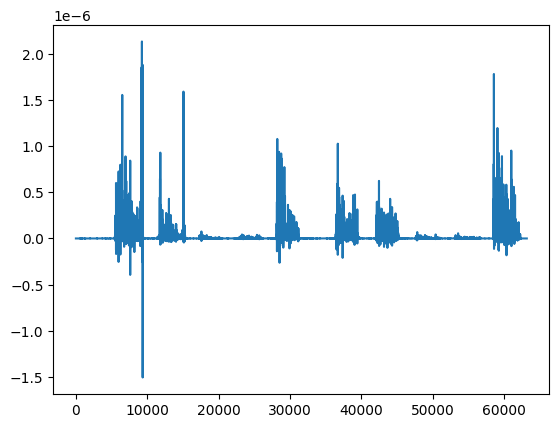

In [6]:
df_tkeo = tkeo_multiple(diccionario_3d[1])
plt.plot(df_tkeo['channel1'])

In [7]:
fs = 200
orden = 32
wn_baja = 10/(fs/2)
wn_alta = 40/(fs/2)
pasaBaja_Fiir = signal.firwin(orden+1, wn_alta, pass_zero = 'lowpass',window='hamming')
pasaAltas_Fiir = signal.firwin(orden+1, wn_baja, pass_zero = 'highpass',window='hamming')

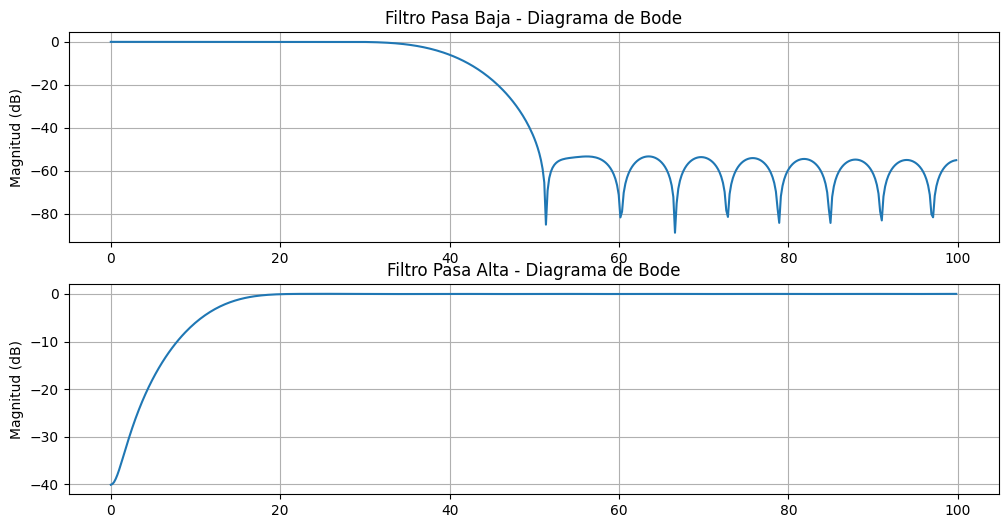

In [8]:
w_baja, h_baja = signal.freqz(pasaBaja_Fiir, fs=fs)
w_alta, h_alta = signal.freqz(pasaAltas_Fiir, fs=fs)


plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(w_baja, 20 * np.log10(abs(h_baja)))
plt.title('Filtro Pasa Baja - Diagrama de Bode')
plt.ylabel('Magnitud (dB)')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(w_alta, 20 * np.log10(abs(h_alta)))
plt.title('Filtro Pasa Alta - Diagrama de Bode')
plt.ylabel('Magnitud (dB)')
plt.grid(True)

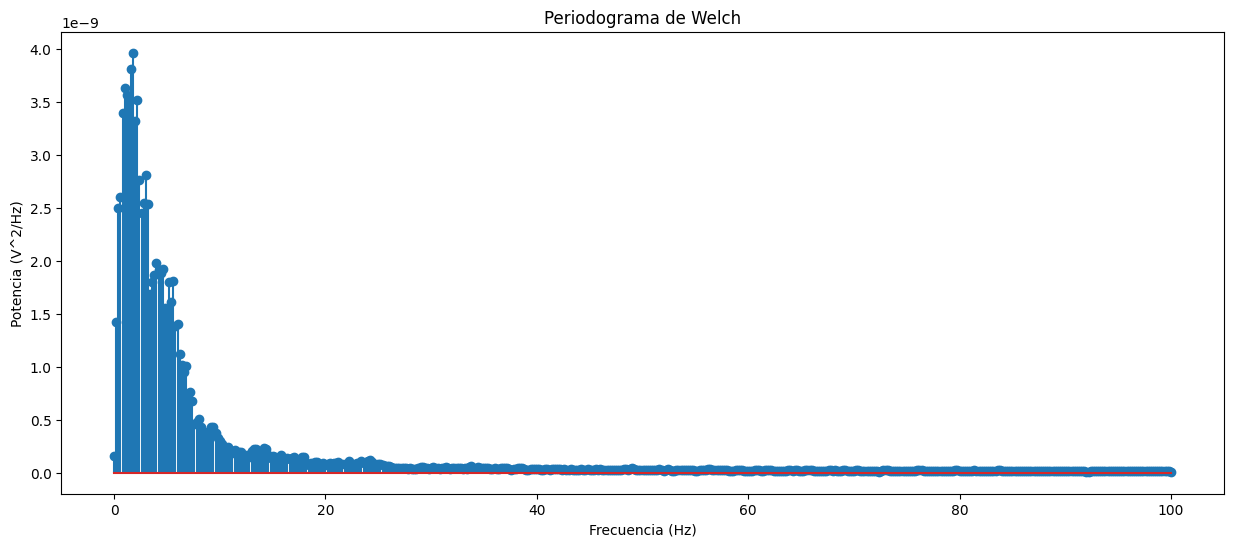

In [9]:
from scipy.signal import welch
from scipy.signal import windows

fs = 200
window_size = 1000  # Tamaño de la ventana de 2000 muestras
overlap = window_size // 2  # Solapamiento del 50%
window = windows.hamming(window_size)

# Periodograma de Welch
f, pxx = welch(diccionario_3d[1]['channel1'], fs=fs, window=window, nperseg=window_size, noverlap=overlap)

plt.figure(figsize=(15, 6))
plt.stem(f, pxx)
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Potencia (V^2/Hz)')
plt.title('Periodograma de Welch')
plt.show()

In [10]:
def filtrar_multicanal(df):
    df_nuevo = df.copy()
    for i in range(8):
        senal = np.array(df_nuevo[f'channel{i+1}'])
        signal_filt = signal.filtfilt(b=pasaBaja_Fiir,a=1,x=senal)
        signal_filtt = signal.filtfilt(b=pasaAltas_Fiir,a=1,x=signal_filt)
        df_nuevo[f'channel{i+1}'] = signal_filtt
    return df_nuevo
    
        

In [11]:

df_filt = filtrar_multicanal(df_tkeo)

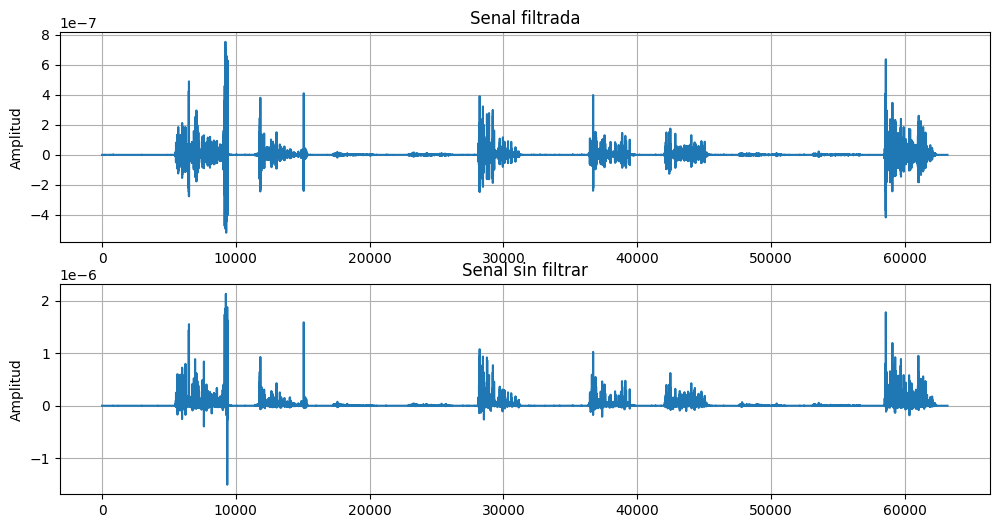

In [12]:
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(df_filt['channel1'])
plt.title('Senal filtrada')
plt.ylabel('Amplitud')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(df_tkeo['channel1'])
plt.title('Senal sin filtrar')
plt.ylabel('Amplitud')
plt.grid(True)

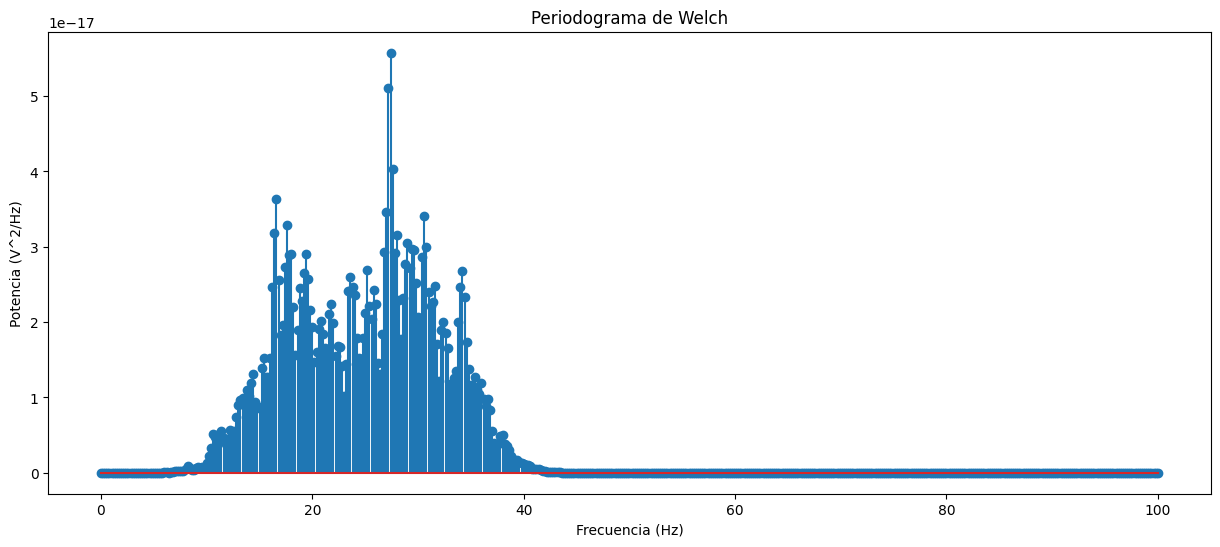

In [13]:
f, pxx = welch(df_filt['channel1'], fs=fs, window=window, nperseg=window_size, noverlap=overlap)
plt.figure(figsize=(15, 6))
plt.stem(f, pxx)
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Potencia (V^2/Hz)')
plt.title('Periodograma de Welch')
plt.show()


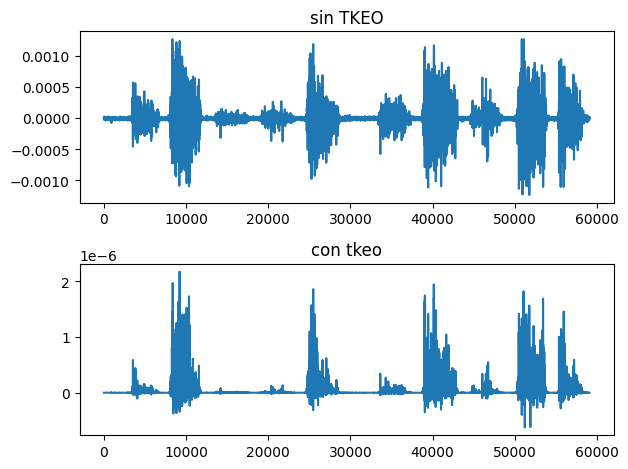

In [14]:
diccionario_Tkeo = {}
i = 0
for pac in diccionario_3d.values():
    i+=1
    diccionario_Tkeo[i] = tkeo_multiple(pac)

plt.figure()  

plt.subplot(2, 1, 1)
plt.plot(diccionario_3d[4]['channel1'])
plt.title('sin TKEO')

plt.subplot(2, 1, 2)
plt.plot(diccionario_Tkeo[4]['channel1'])
plt.title('con tkeo')

plt.tight_layout()

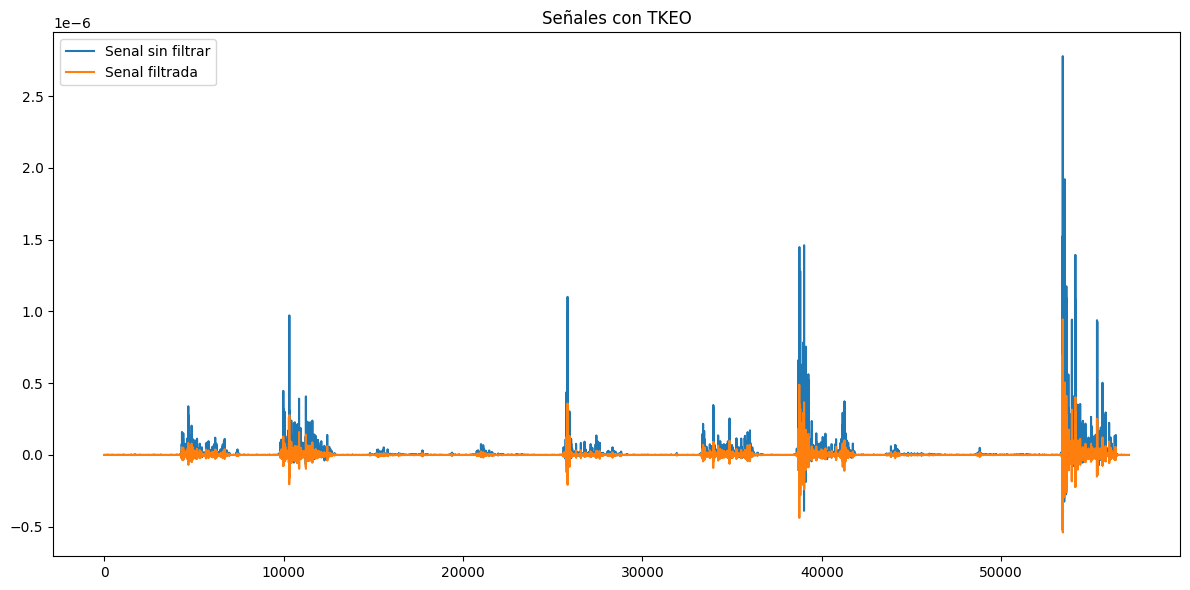

In [15]:
diccionario_Tkeo_filt = {}
i = 0
for pac in diccionario_Tkeo.values():
    i+=1
    diccionario_Tkeo_filt[i] = filtrar_multicanal(pac)

plt.figure(figsize=(12, 6))  

plt.plot(diccionario_Tkeo[5]['channel1'],label = 'Senal sin filtrar')
plt.plot(diccionario_Tkeo_filt[5]['channel1'], label = 'Senal filtrada')
plt.title('Señales con TKEO')
plt.legend()

plt.tight_layout()

In [16]:
def calcularRMS(X):
  N=X.size #Cantidad de puntos
  rms=(np.sum(X**(2))/N)**0.5
  return rms

In [17]:
def var_est(df):
    res_canales_list = []
    estadisticas = ['class','C_1RMS', 'C_1Var', 'C_1MAV', 'C_1MAVS', 'C_1SSC', 'C_1WL', 'C_1ZC',
                    'C_2RMS', 'C_2Var', 'C_2MAV', 'C_2MAVS', 'C_2SSC', 'C_2WL', 'C_2ZC',
                    'C_3RMS', 'C_3Var', 'C_3MAV', 'C_3MAVS', 'C_3SSC', 'C_3WL', 'C_3ZC',
                    'C_4RMS', 'C_4Var', 'C_4MAV', 'C_4MAVS', 'C_4SSC', 'C_4WL', 'C_4ZC',
                    'C_5RMS', 'C_5Var', 'C_5MAV', 'C_5MAVS', 'C_5SSC', 'C_5WL', 'C_5ZC',
                    'C_6RMS', 'C_6Var', 'C_6MAV', 'C_6MAVS', 'C_6SSC', 'C_6WL', 'C_6ZC',
                    'C_7RMS', 'C_7Var', 'C_7MAV', 'C_7MAVS', 'C_7SSC', 'C_7WL', 'C_7ZC',
                    'C_8RMS', 'C_8Var', 'C_8MAV', 'C_8MAVS', 'C_8SSC', 'C_8WL', 'C_8ZC']
    clase = []
    for i in range(8):
        clase = [i]
        lista_move = [] 
        df_p1 = df[df['class'] == i] 
        for j in range(8):
            arreglo = np.array(df_p1[f'channel{j+1}'])
            rms = calcularRMS(arreglo)
            var = np.var(arreglo)
            mean = np.mean(np.abs(arreglo))
            mean_slope = np.mean(np.abs(np.diff(arreglo)))
            sl_sign_c = np.sum(np.abs(np.diff(np.sign(np.diff(arreglo)))))
            wl_values = np.sum(np.abs(np.diff(arreglo)))
            zero_crossings = np.sum(np.diff(np.sign(arreglo)))
            lista = [rms, var, mean, mean_slope, sl_sign_c, wl_values, zero_crossings]
            lista_move.extend(lista)
        
        clase.extend(lista_move)        
        res_canales_list.append(clase)
        
    df_estadisticas = pd.DataFrame(res_canales_list, columns=estadisticas)
    return df_estadisticas

In [18]:
def build_final_df(diccionario):
    i = 0
    df_final_Tkeo = pd.DataFrame()
    for pac in diccionario.values():
        i+=1
        df_np = pd.DataFrame({'Sujeto': (np.ones(8, dtype=int))* i,'class': np.arange(0, 8)})
        df_final = var_est(pac)
        df_final = pd.merge(df_np, df_final, how = 'left', on = 'class')
        df_final_Tkeo = pd.concat([df_final_Tkeo,df_final],axis=0)
        df_final_Tkeo = df_final_Tkeo.fillna(0)
    return df_final_Tkeo
      

In [19]:
df_final_Tkeo = build_final_df(diccionario_Tkeo)
df_final_Tkeo_filt = build_final_df(diccionario_Tkeo_filt)

C:\Users\Juan Manuel\AppData\Local\Temp\ipykernel_24312\2966749409.py:3: RuntimeWarning: invalid value encountered in scalar divide
  rms=(np.sum(X**(2))/N)**0.5
C:\Users\Juan Manuel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Juan Manuel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\Juan Manuel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / r

In [20]:
condicion = df_final_Tkeo['class'] == 0
df_final_Tkeo = df_final_Tkeo.drop(index=df_final_Tkeo[condicion].index)
df_final_Tkeo

,Sujeto,class,C_1RMS,C_1Var,C_1MAV,C_1MAVS,C_1SSC,C_1WL,C_1ZC,C_2RMS,...,C_7SSC,C_7WL,C_7ZC,C_8RMS,C_8Var,C_8MAV,C_8MAVS,C_8SSC,C_8WL,C_8ZC
1,1,1,2.036246e-10,4.021190e-20,4.505291e-11,7.700450e-11,1150.0,2.910000e-07,0.0,6.175412e-10,...,1123.0,2.062000e-07,1.0,1.452875e-10,2.042391e-20,3.373016e-11,5.856047e-11,1181.0,2.213000e-07,-1.0
2,1,2,6.102474e-08,3.624883e-15,1.171336e-08,1.747182e-08,1279.0,6.157070e-05,1.0,1.394133e-08,...,1245.0,5.259270e-05,-1.0,2.615771e-08,6.601893e-16,5.615915e-09,8.235953e-09,1201.0,2.902350e-05,1.0
3,1,3,2.883578e-08,8.014632e-16,6.422799e-09,9.658087e-09,1298.0,3.684560e-05,0.0,4.346832e-08,...,1236.0,6.412800e-06,0.0,2.221483e-08,4.761333e-16,4.738208e-09,6.765557e-09,1282.0,2.581060e-05,0.0
4,1,4,2.415744e-09,5.625702e-18,5.387678e-10,7.895349e-10,1196.0,2.716000e-06,0.0,7.663082e-09,...,1204.0,1.223960e-05,0.0,5.051364e-09,2.468358e-17,1.083697e-09,1.603198e-09,1200.0,5.515000e-06,0.0
5,1,5,2.378870e-09,5.424352e-18,5.378700e-10,7.465412e-10,1066.0,2.698000e-06,2.0,1.201542e-08,...,1130.0,7.648100e-06,0.0,2.790829e-09,7.560474e-18,5.577040e-10,8.427504e-10,1116.0,3.045700e-06,-2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,36,3,4.020941e-08,1.563179e-15,8.440877e-09,1.219961e-08,1127.0,3.756260e-05,1.0,1.175082e-08,...,1107.0,6.995000e-06,1.0,6.531037e-09,4.082018e-17,1.539675e-09,2.197272e-09,1111.0,6.765400e-06,-1.0
4,36,4,1.850992e-09,3.288742e-18,4.300410e-10,6.212121e-10,1146.0,1.968000e-06,0.0,2.763945e-09,...,1164.0,5.445200e-06,0.0,1.902917e-09,3.445692e-18,4.757337e-10,6.991162e-10,1154.0,2.214800e-06,0.0
5,36,5,2.276129e-08,4.958364e-16,5.403088e-09,7.866903e-09,1072.0,2.215320e-05,0.0,2.193065e-08,...,986.0,1.236200e-06,0.0,1.248609e-09,1.501930e-18,2.828186e-10,4.254261e-10,992.0,1.198000e-06,0.0
6,36,6,1.184596e-08,1.353901e-16,2.510870e-09,3.747448e-09,1109.0,1.071770e-05,1.0,3.690457e-09,...,1159.0,1.039000e-05,-1.0,1.849131e-08,3.289931e-16,4.012513e-09,5.814580e-09,1117.0,1.662970e-05,-1.0


In [21]:
condicion = df_final_Tkeo_filt['class'] == 0
df_final_Tkeo_filt = df_final_Tkeo_filt.drop(index=df_final_Tkeo_filt[condicion].index)
df_final_Tkeo_filt

,Sujeto,class,C_1RMS,C_1Var,C_1MAV,C_1MAVS,C_1SSC,C_1WL,C_1ZC,C_2RMS,...,C_7SSC,C_7WL,C_7ZC,C_8RMS,C_8Var,C_8MAV,C_8MAVS,C_8SSC,C_8WL,C_8ZC
1,1,1,9.856792e-11,9.715630e-21,4.760260e-11,3.839132e-11,2448.0,1.450808e-07,0.0,2.995875e-10,...,2464.0,9.864386e-08,0.0,6.630441e-11,4.396275e-21,3.408171e-11,2.824280e-11,2414.0,1.067296e-07,-2.0
2,1,2,3.098198e-08,9.598825e-16,1.249268e-08,9.830496e-09,2196.0,3.464267e-05,-2.0,7.894071e-09,...,2220.0,2.976500e-05,-2.0,1.371545e-08,1.881137e-16,6.297821e-09,4.972604e-09,2224.0,1.752346e-05,-2.0
3,1,3,1.486692e-08,2.210254e-16,7.074607e-09,5.713289e-09,2466.0,2.179620e-05,0.0,2.273063e-08,...,2418.0,3.848466e-06,2.0,1.228466e-08,1.509128e-16,5.355145e-09,4.267062e-09,2448.0,1.627884e-05,2.0
4,1,4,1.297642e-09,1.683869e-18,5.874935e-10,4.685314e-10,2192.0,1.611748e-06,2.0,4.064778e-09,...,2180.0,7.137138e-06,2.0,2.634088e-09,6.938418e-18,1.171036e-09,9.297581e-10,2190.0,3.198368e-06,2.0
5,1,5,1.289533e-09,1.662894e-18,6.243978e-10,4.942217e-10,2330.0,1.786117e-06,-2.0,6.484814e-09,...,2318.0,4.522455e-06,-2.0,1.404575e-09,1.972830e-18,6.200916e-10,4.925210e-10,2318.0,1.779971e-06,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,36,3,2.134241e-08,4.554898e-16,9.467962e-09,7.392429e-09,1920.0,2.276129e-05,2.0,6.030924e-09,...,1914.0,4.041882e-06,2.0,3.528192e-09,1.244802e-17,1.679516e-09,1.342337e-09,1928.0,4.133056e-06,2.0
4,36,4,1.009567e-09,1.019226e-18,4.617788e-10,3.647492e-10,1986.0,1.155526e-06,0.0,1.519811e-09,...,1974.0,3.330555e-06,-2.0,1.028587e-09,1.057992e-18,5.246074e-10,4.137800e-10,1962.0,1.310855e-06,-2.0
5,36,5,1.174665e-08,1.379831e-16,5.877146e-09,4.581388e-09,1792.0,1.290119e-05,0.0,1.133537e-08,...,1746.0,7.211780e-07,0.0,6.285989e-10,3.951343e-19,3.028874e-10,2.379378e-10,1798.0,6.700330e-07,-2.0
6,36,6,6.021556e-09,3.625914e-17,2.776581e-09,2.187022e-09,1762.0,6.254884e-06,0.0,1.904452e-09,...,1788.0,6.012132e-06,-2.0,9.804704e-09,9.613162e-17,4.577889e-09,3.622354e-09,1804.0,1.035993e-05,-2.0


<Figure size 3000x800 with 0 Axes>

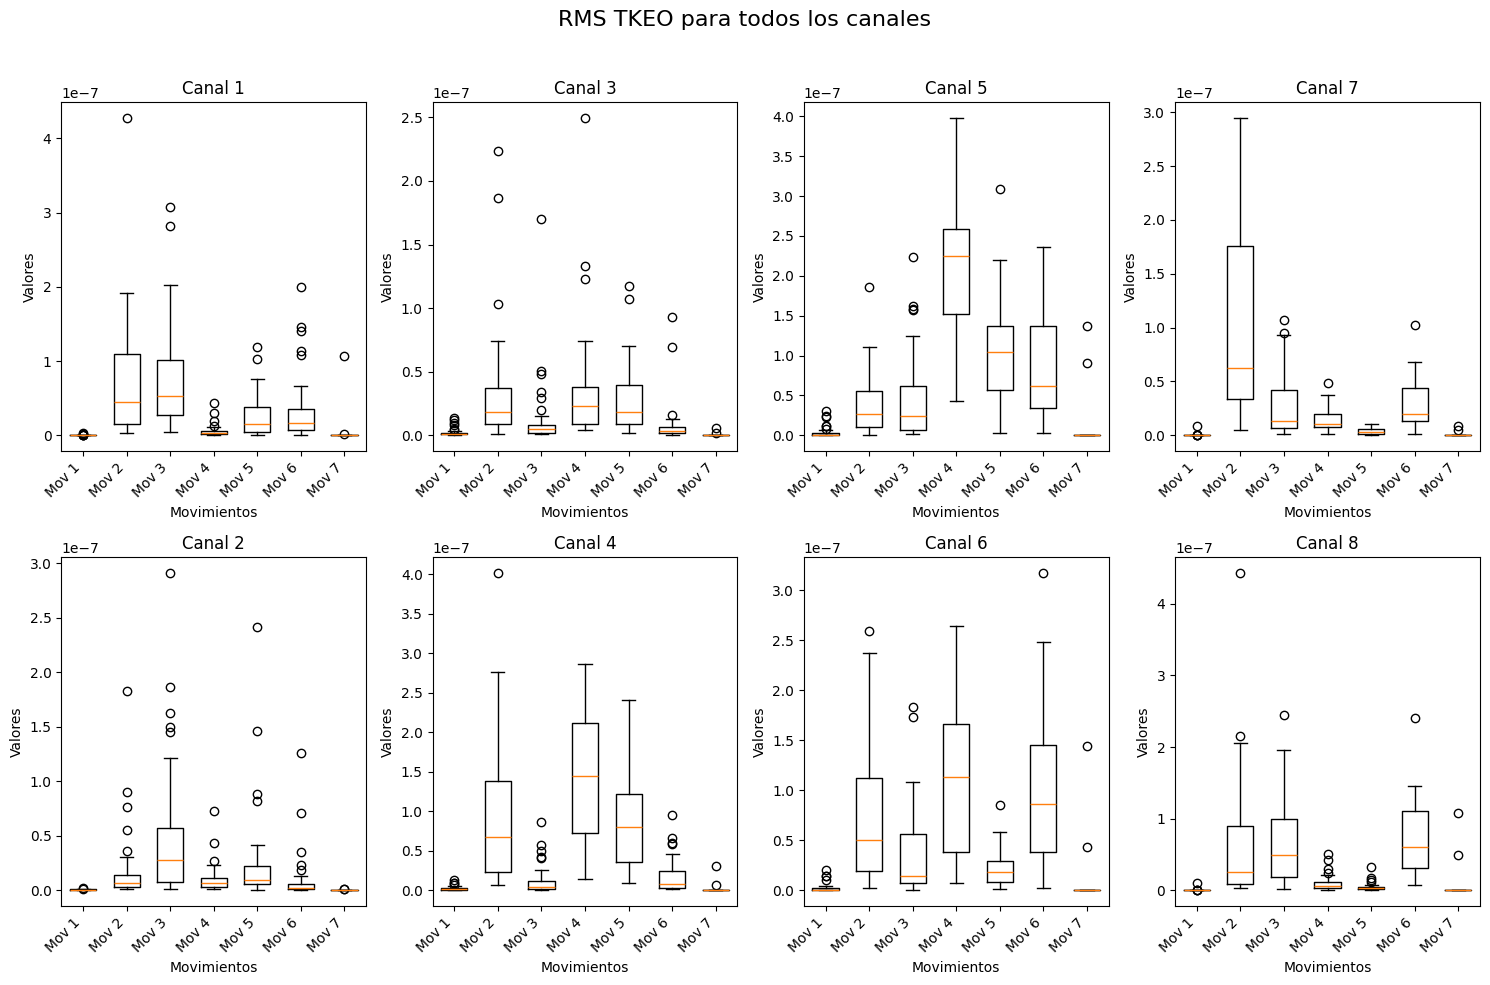

<Figure size 3000x800 with 0 Axes>

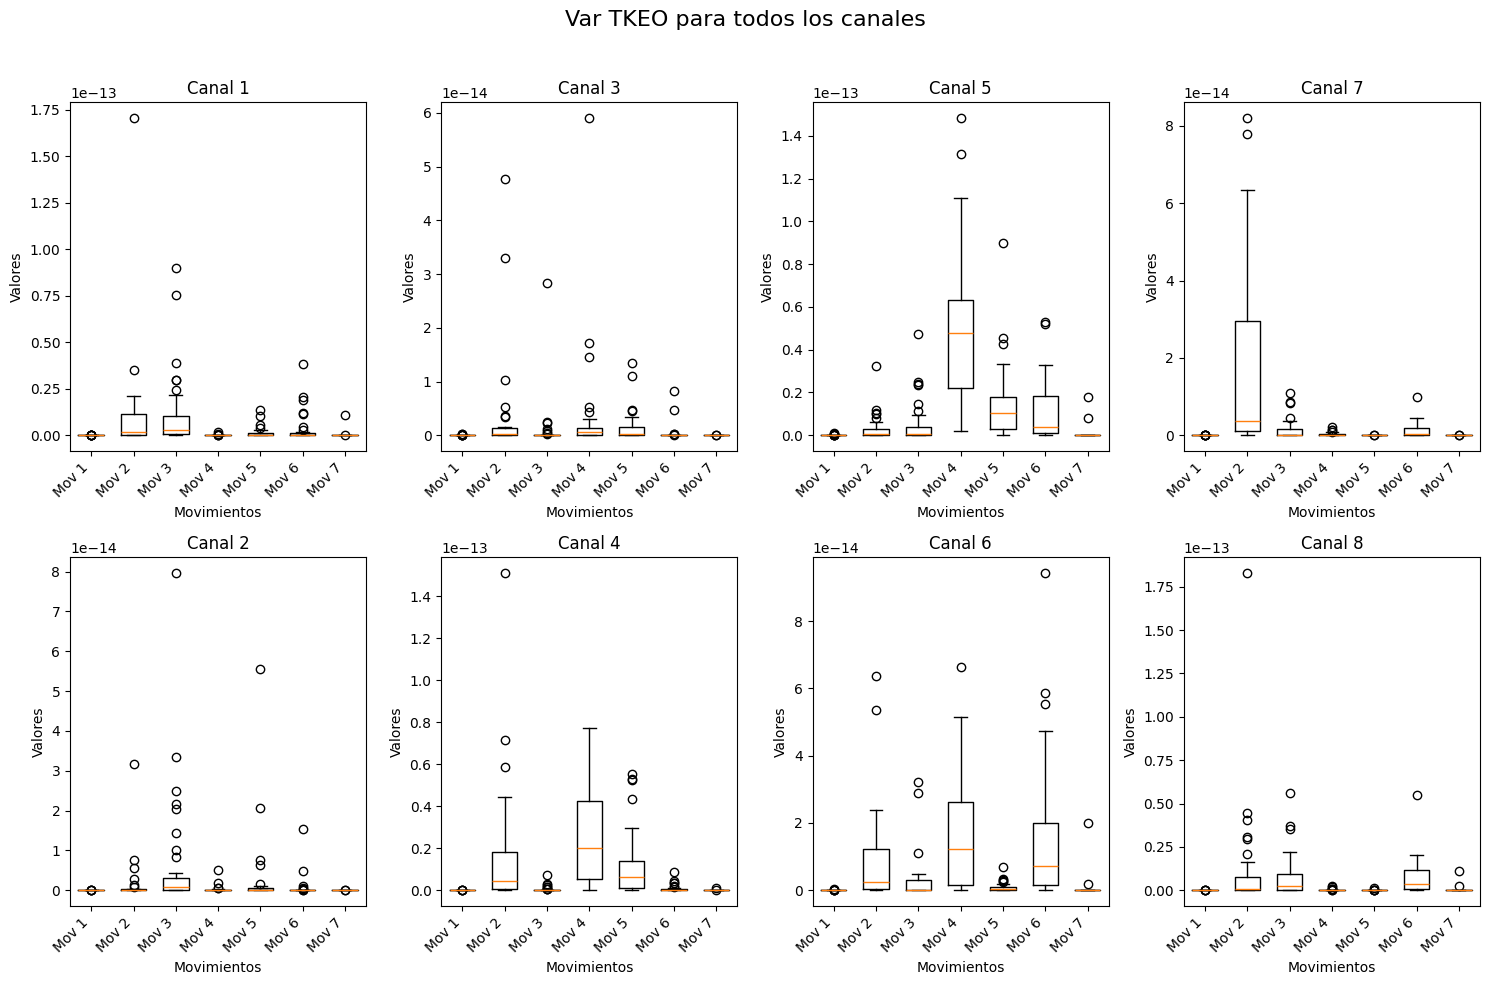

<Figure size 3000x800 with 0 Axes>

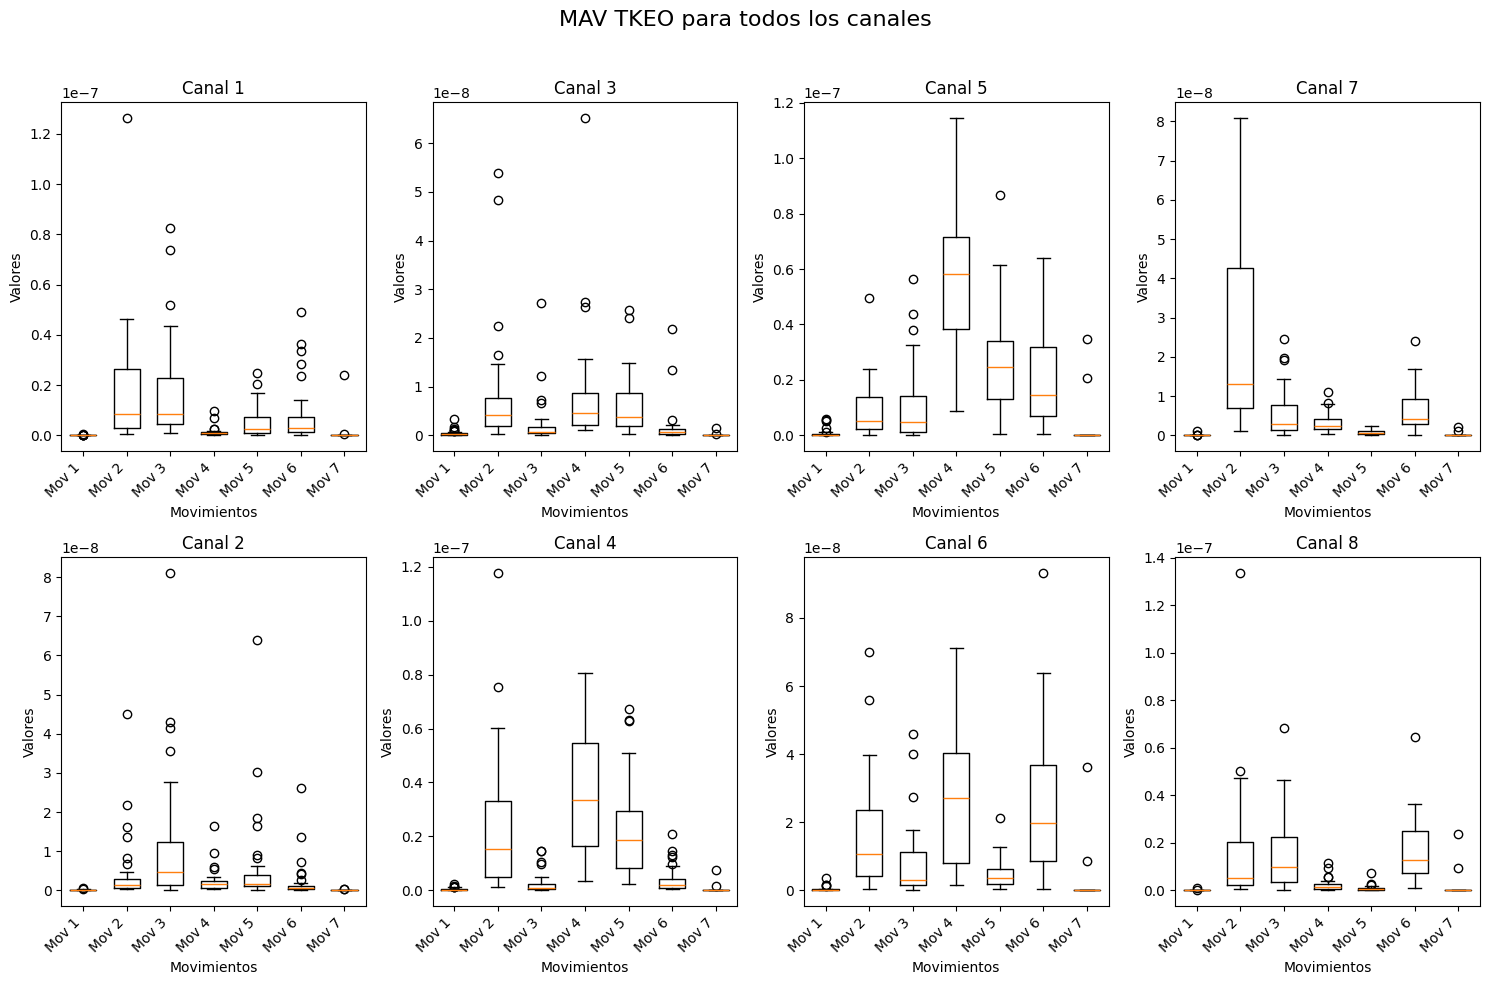

<Figure size 3000x800 with 0 Axes>

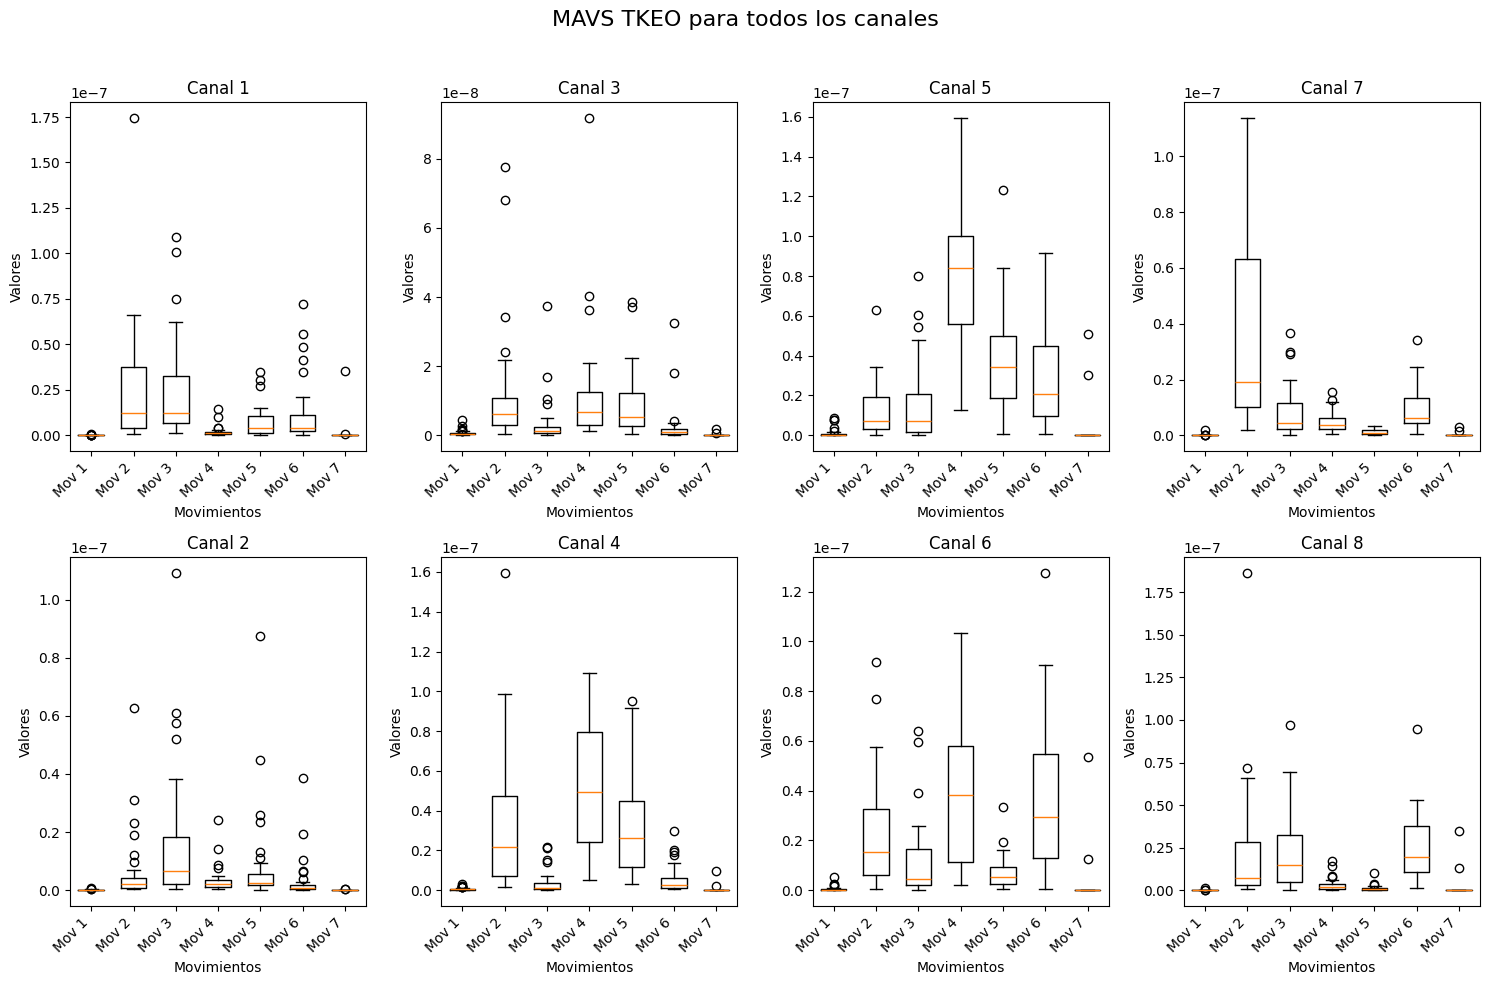

<Figure size 3000x800 with 0 Axes>

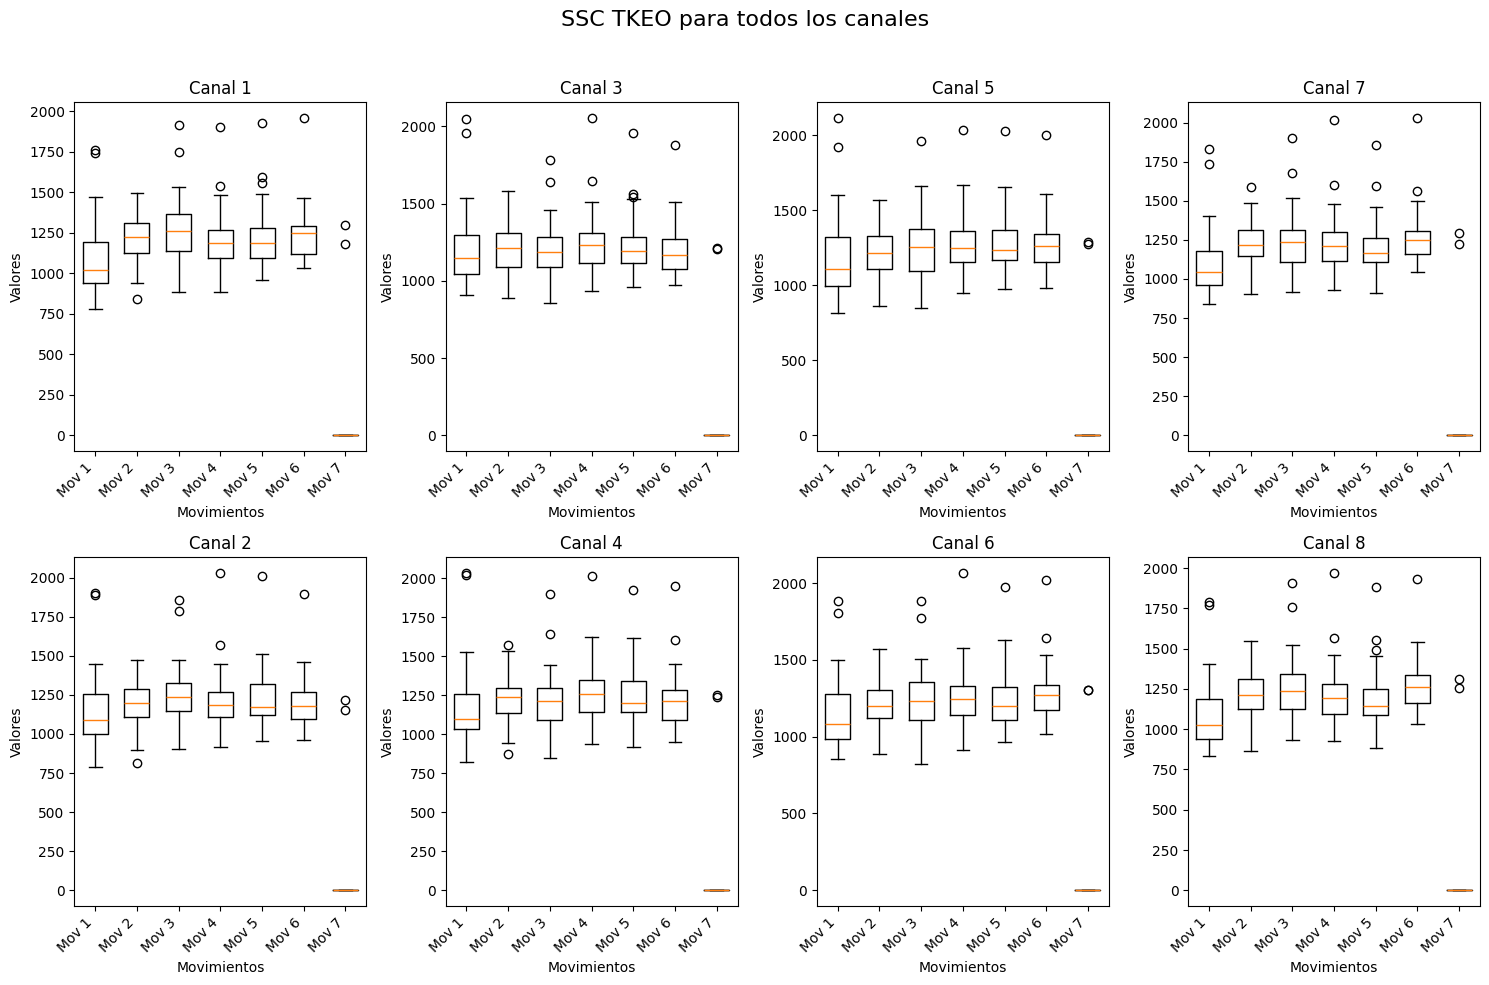

<Figure size 3000x800 with 0 Axes>

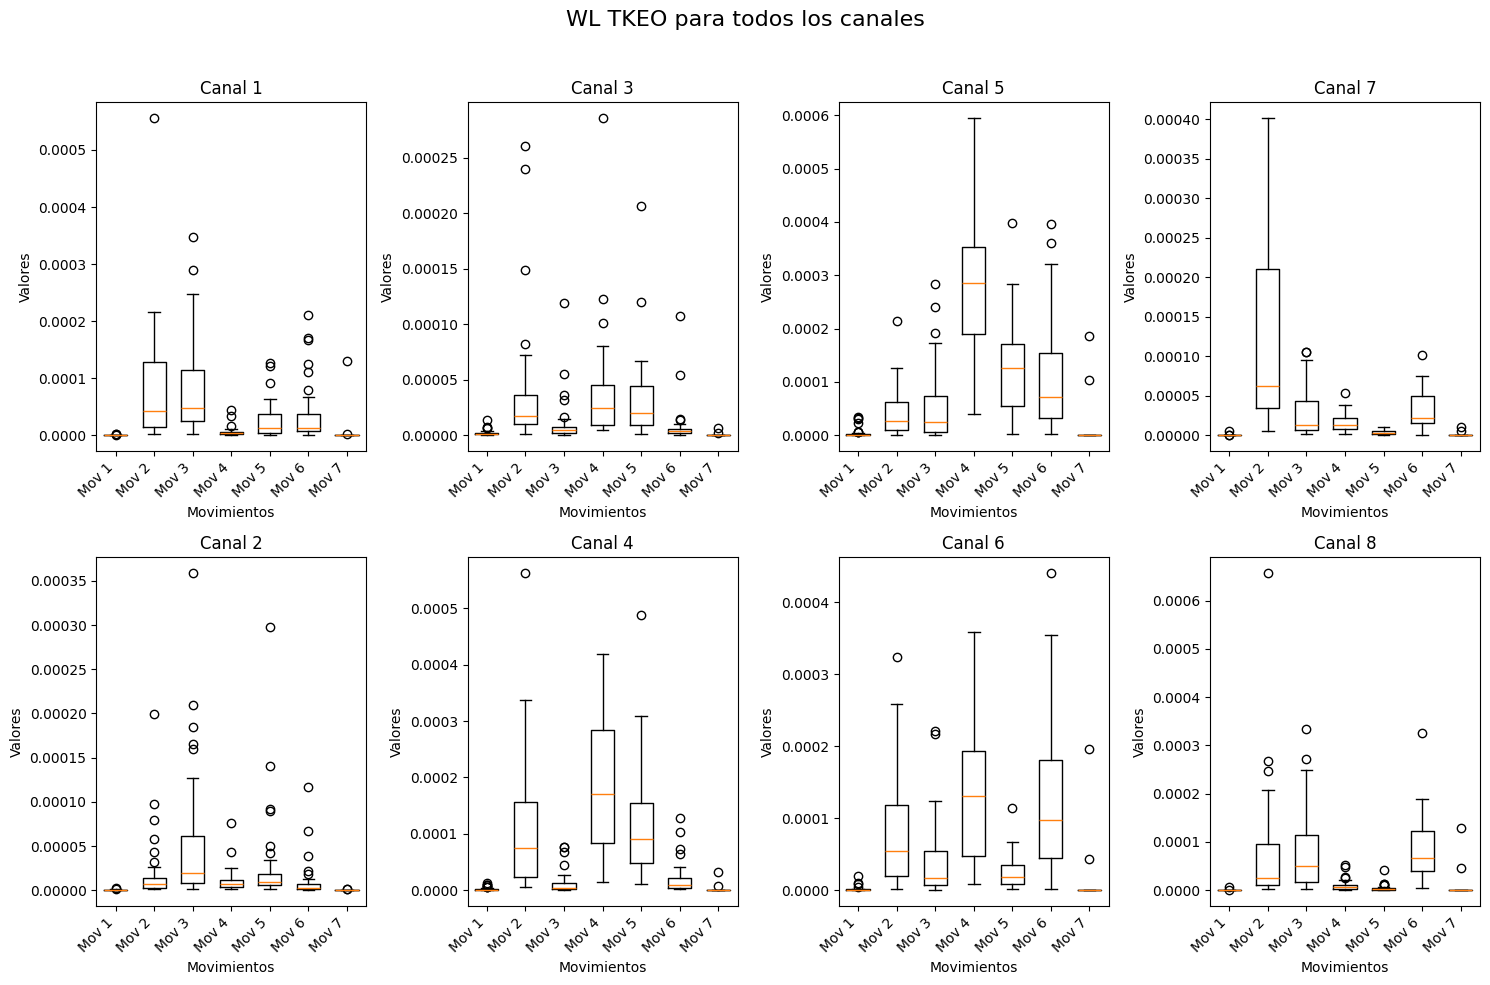

<Figure size 3000x800 with 0 Axes>

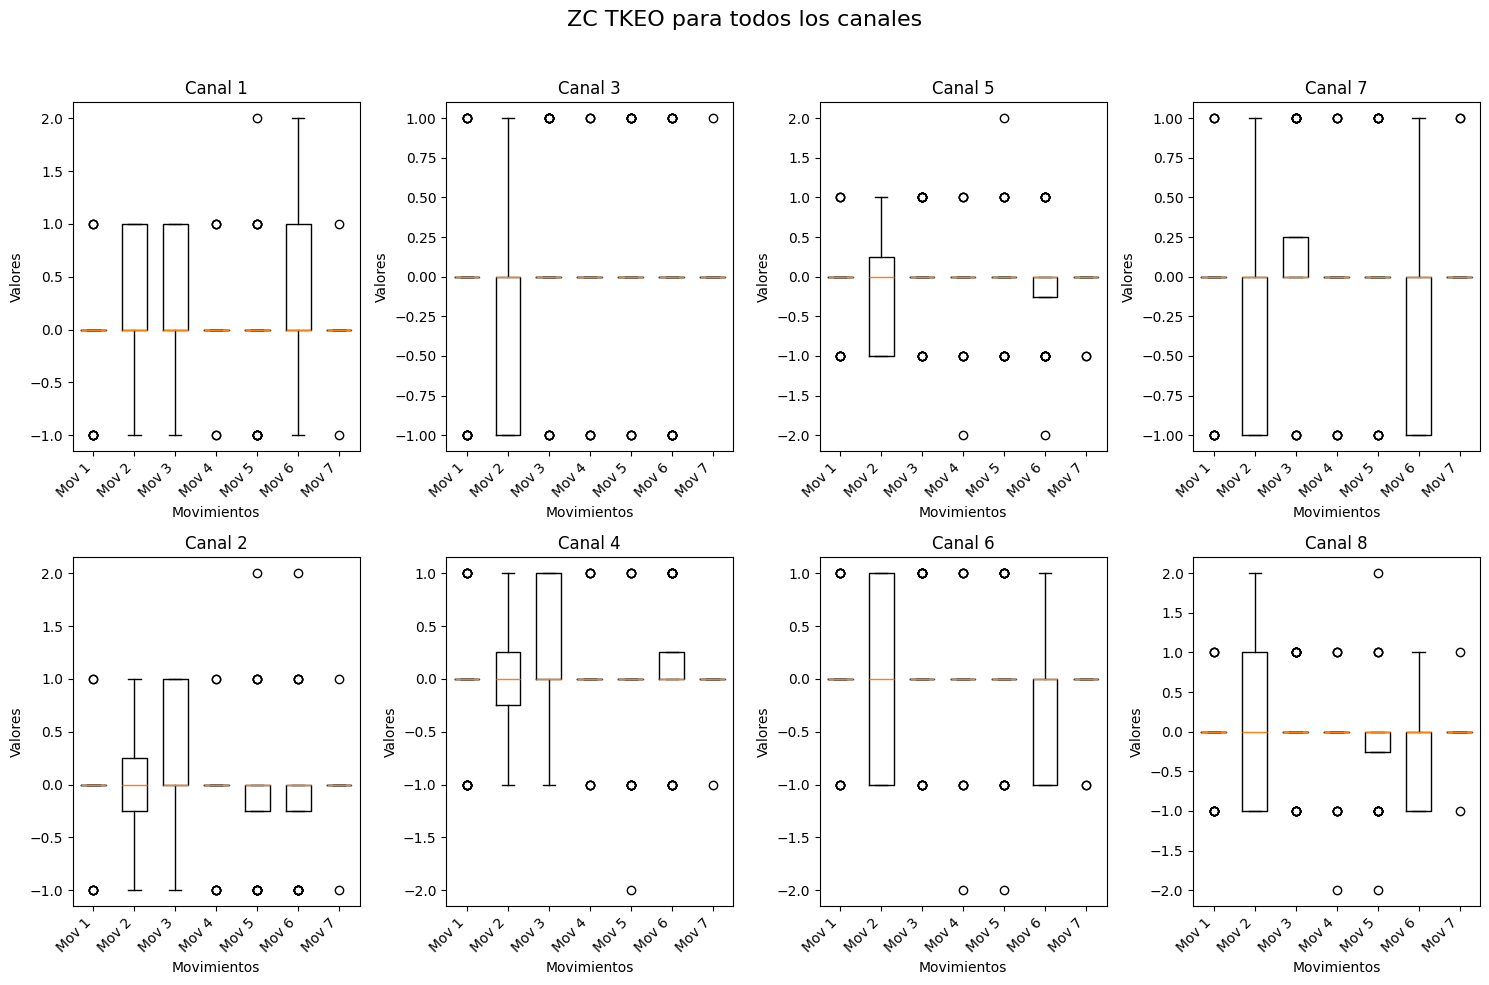

In [22]:
estadisticas = ['RMS', 'Var', 'MAV', 'MAVS', 'SSC', 'WL', 'ZC']
n_movimientos = 8  # Número de movimientos (clases)
n_canales = 8  # Número de canales
posiciones = np.arange(1, n_movimientos)  # Posiciones para los boxplots

for l in estadisticas:
    plt.figure(figsize=(30, 8))
    fig, axs = plt.subplots(2, 4, figsize=(15, 10))  # 4 filas, 2 columnas
    fig.suptitle(f'{l} TKEO para todos los canales', fontsize=16)

    for j in range(1, n_canales + 1):  # Iterar sobre cada canal
        lista_canales = []
        for i in np.arange(1,n_movimientos):  # Iterar sobre cada movimiento
            df_final_Tkeo_mov1 = df_final_Tkeo[df_final_Tkeo['class'] == i]
            lista_RMSc1 = np.array(df_final_Tkeo_mov1[f'C_{j}{l}'])
            lista_canales.append(lista_RMSc1)
        
        ax = axs[(j-1) % 2, (j-1) // 2]  # Seleccionar el subplot apropiado
        bplot1 = ax.boxplot(lista_canales, positions=posiciones, widths=0.6)
        ax.set_xticks(posiciones)
        ax.set_xticklabels([f'Mov {i}' for i in np.arange(1,n_movimientos)], rotation=45, ha='right')

        ax.set_title(f'Canal {j}')
        ax.set_xlabel('Movimientos')
        ax.set_ylabel('Valores')

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Ajustar el layout para que el título no se solape
    plt.show()


<Figure size 3000x800 with 0 Axes>

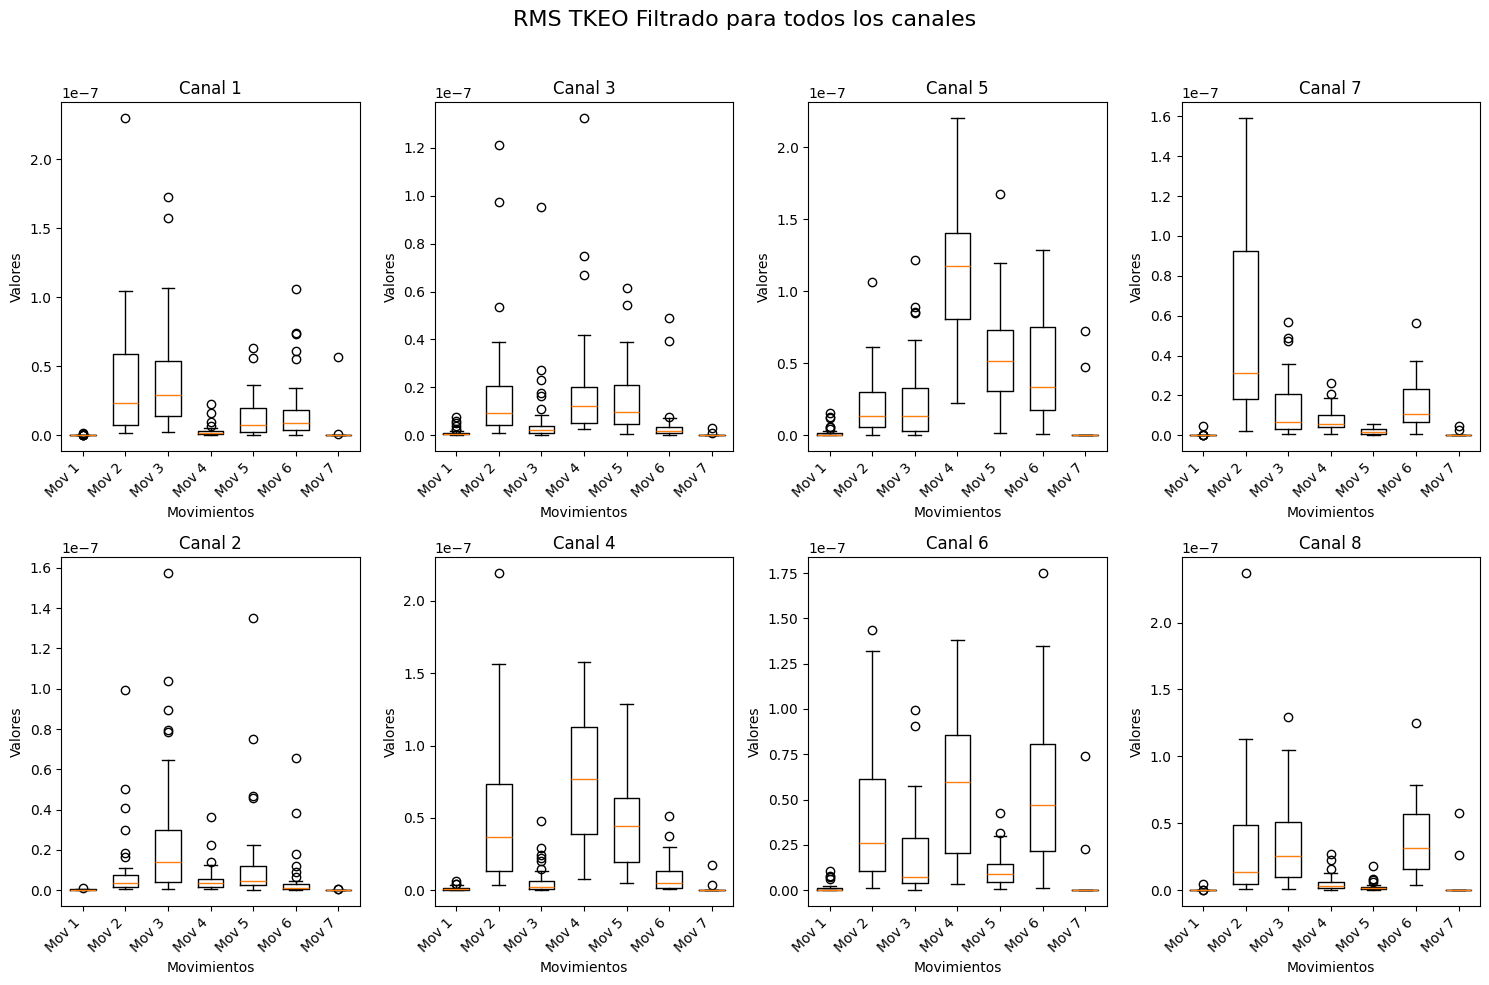

<Figure size 3000x800 with 0 Axes>

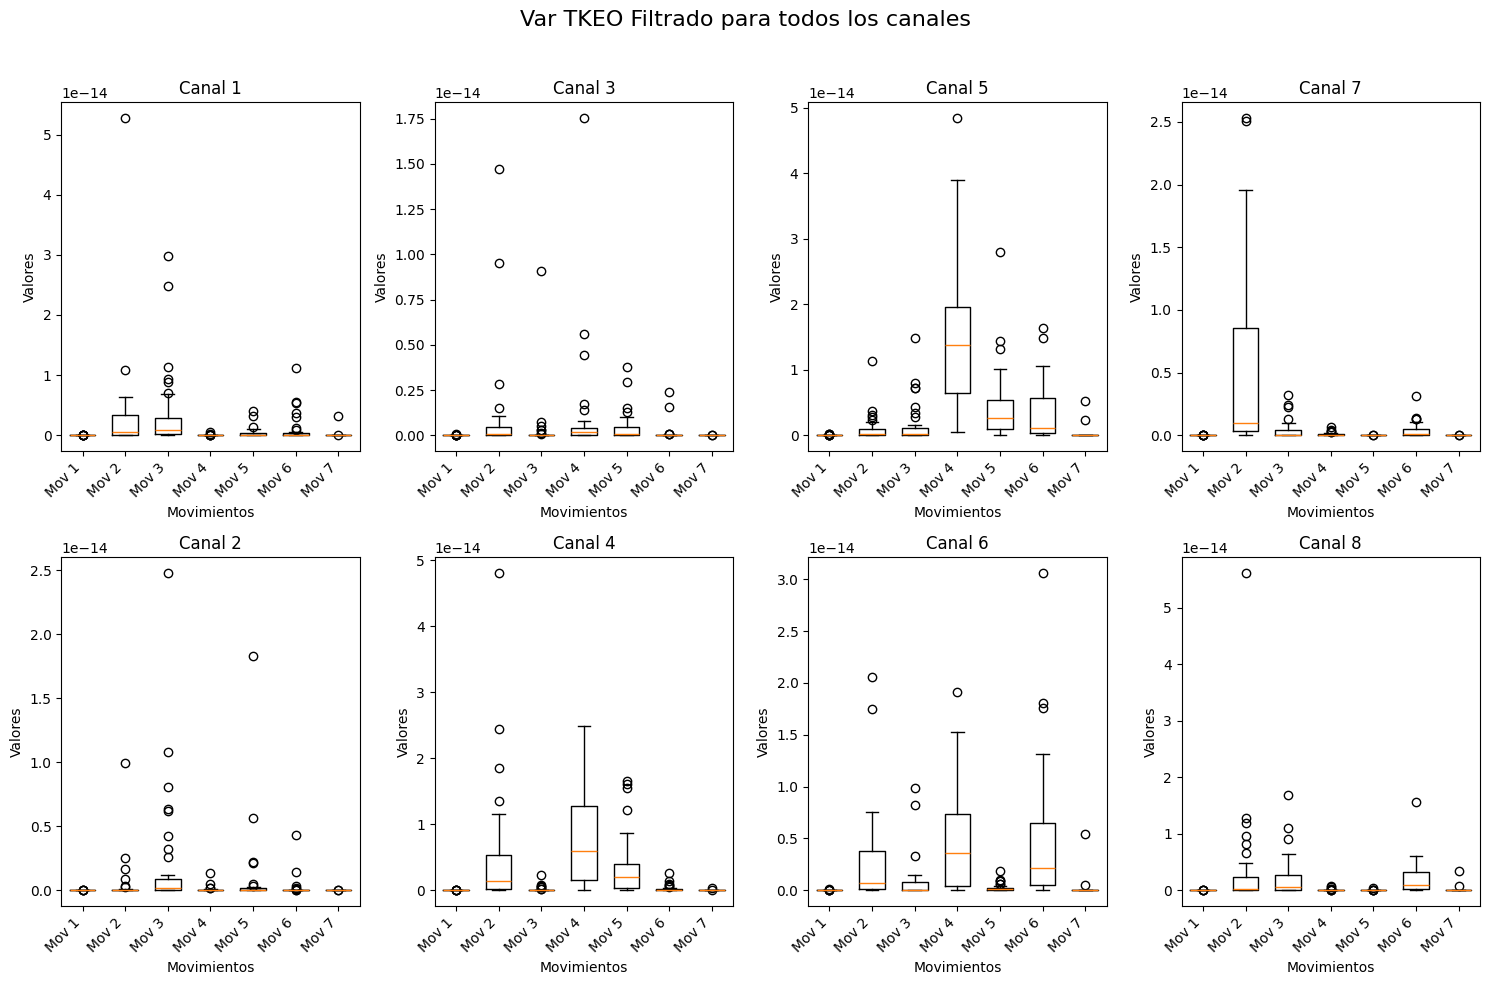

<Figure size 3000x800 with 0 Axes>

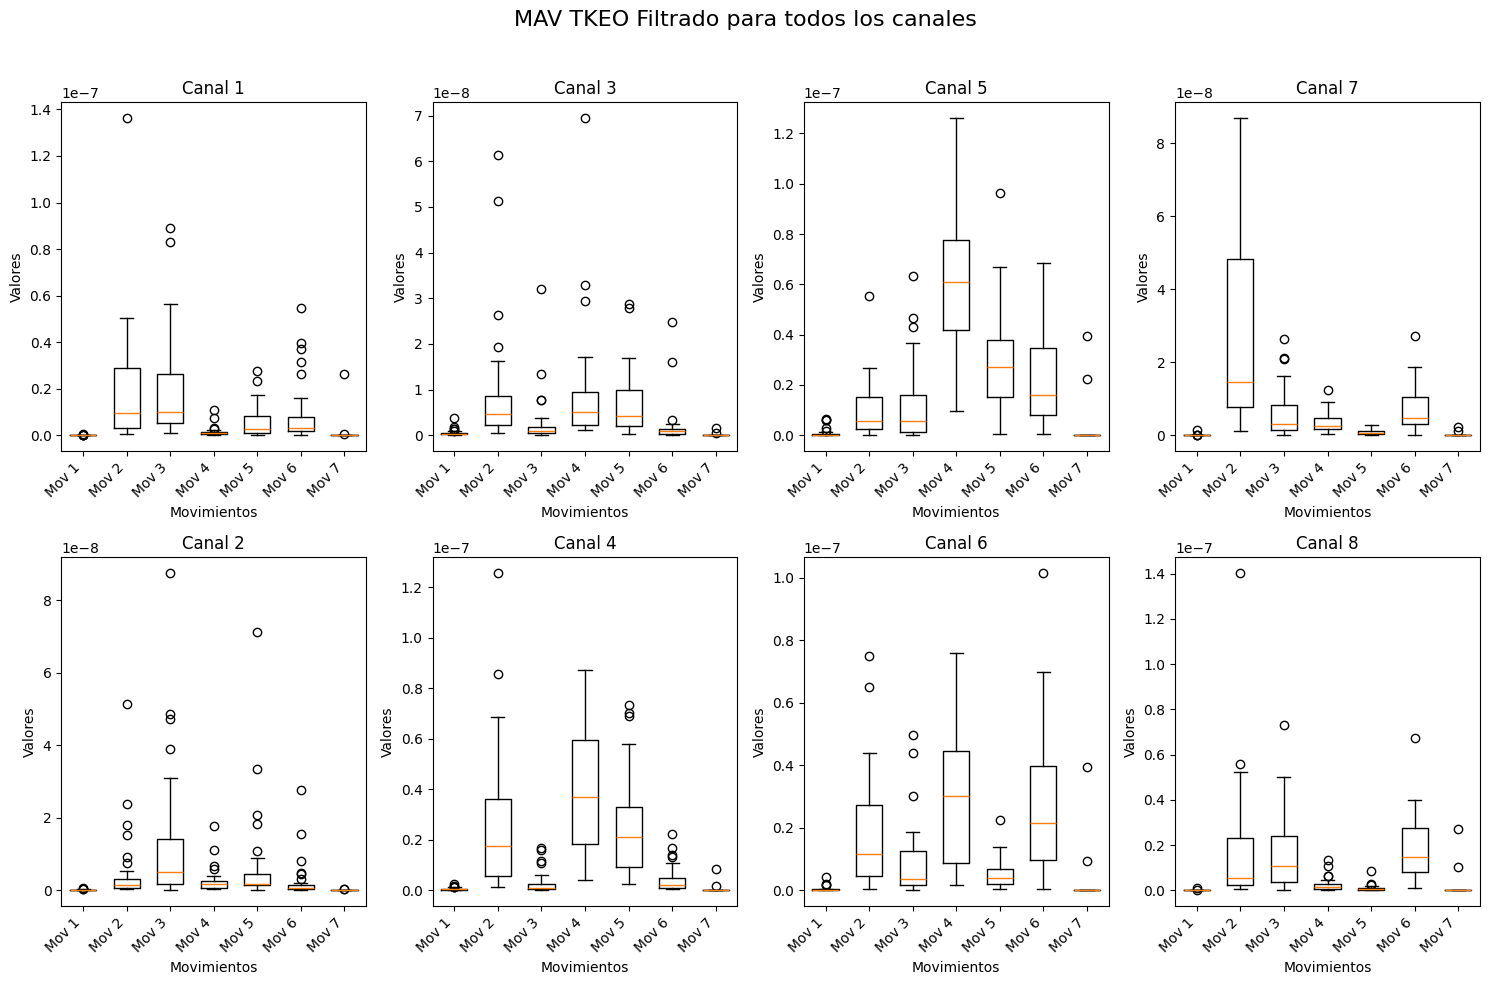

<Figure size 3000x800 with 0 Axes>

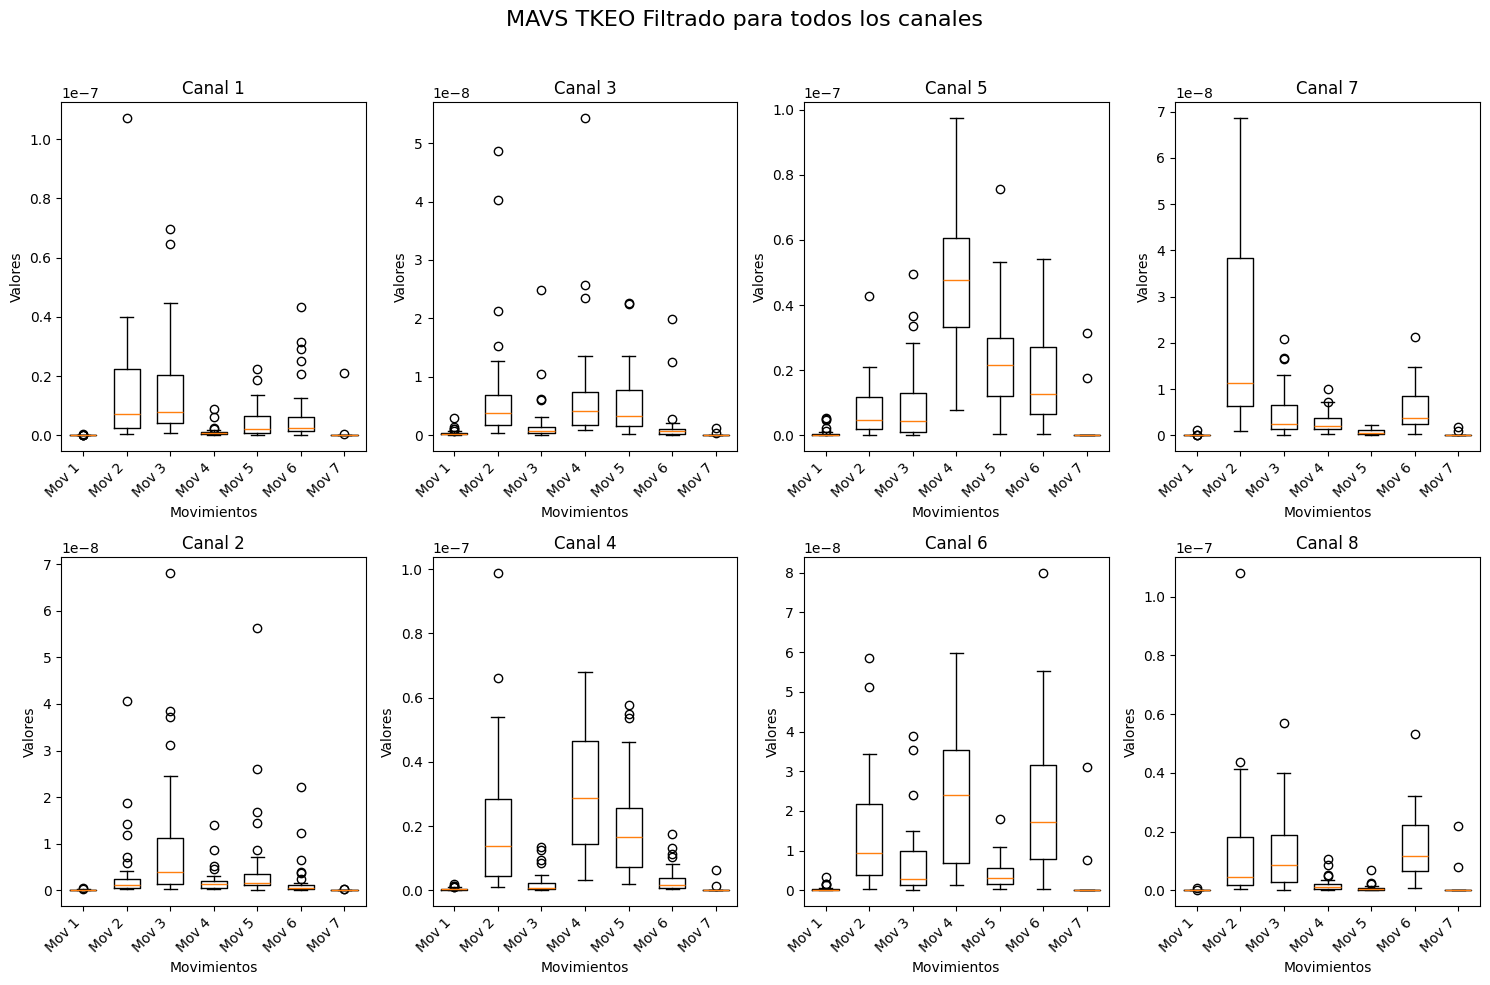

<Figure size 3000x800 with 0 Axes>

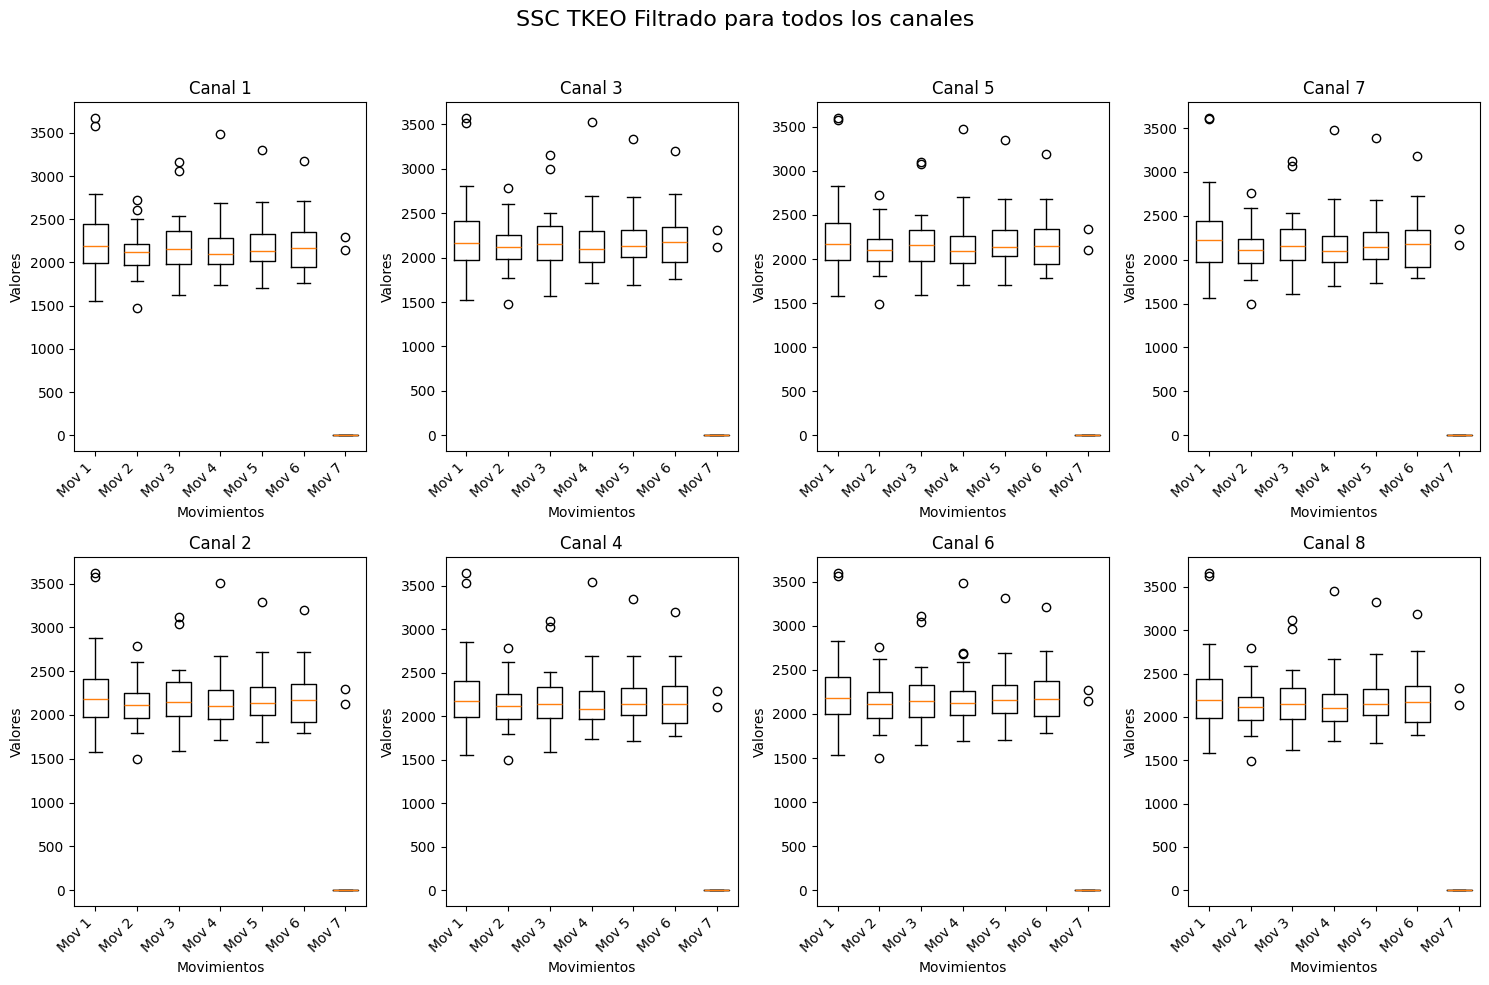

<Figure size 3000x800 with 0 Axes>

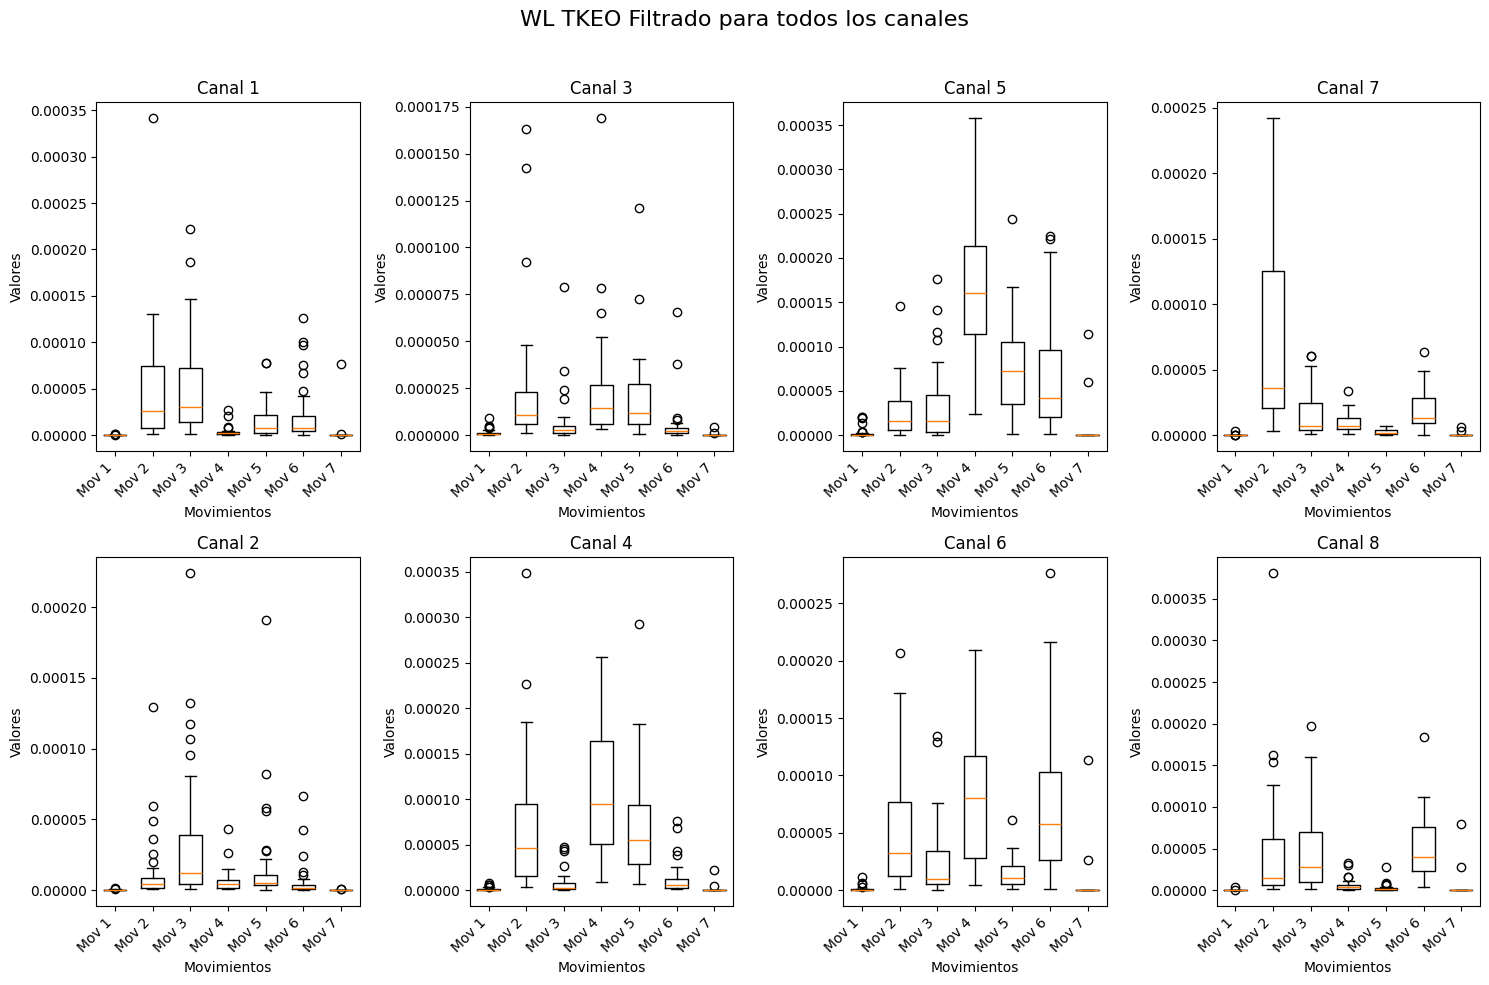

<Figure size 3000x800 with 0 Axes>

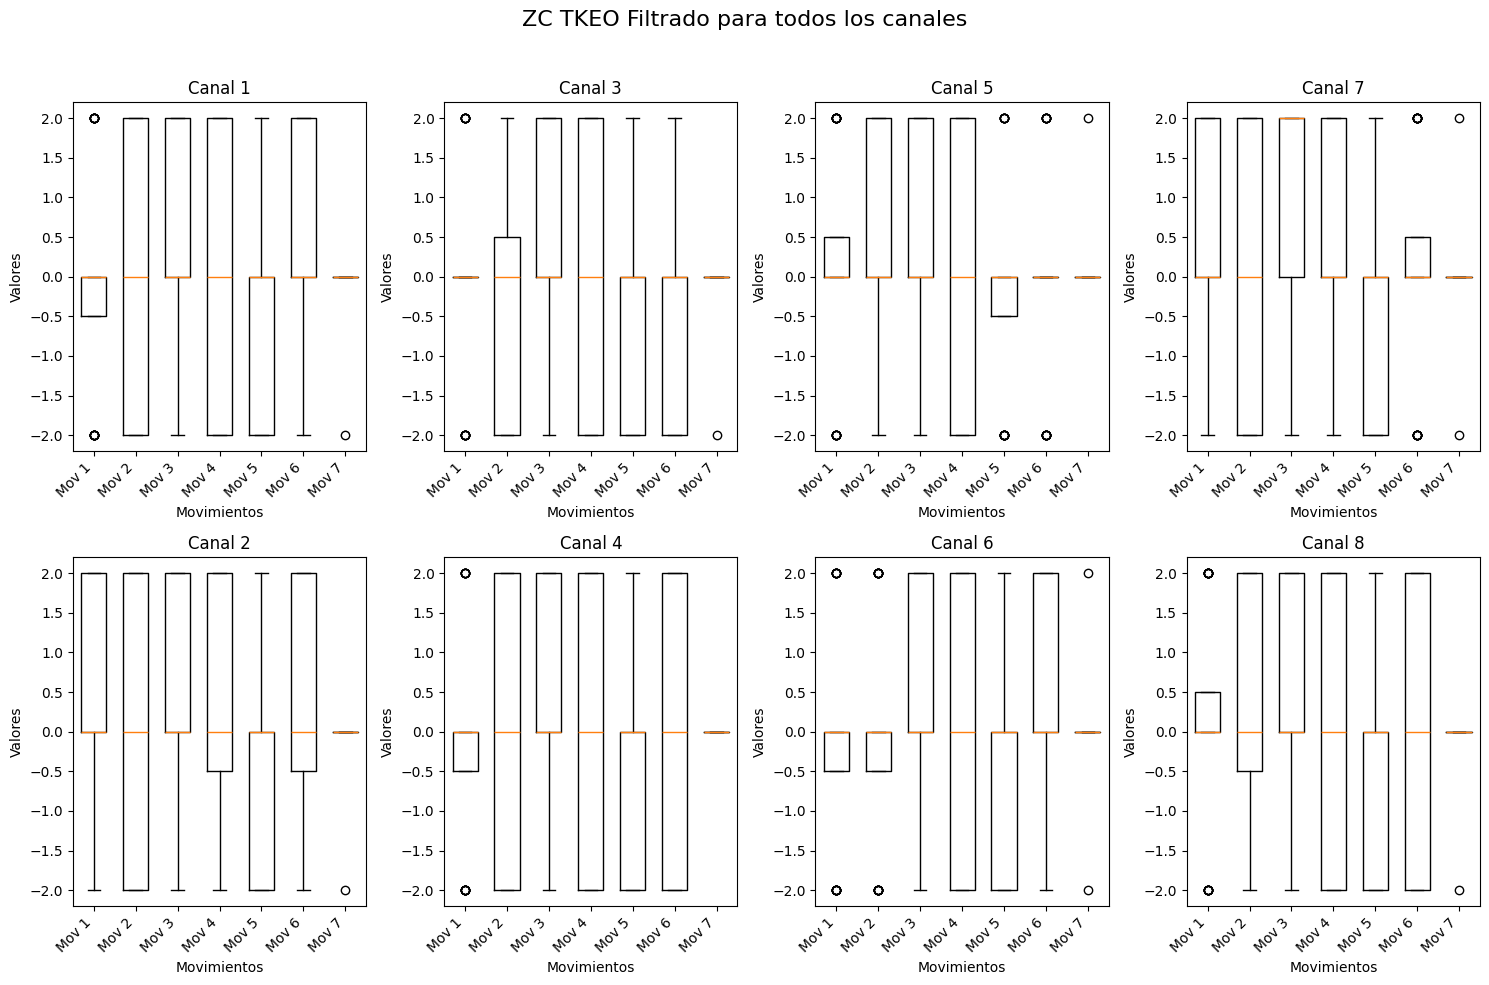

In [23]:
estadisticas = ['RMS', 'Var', 'MAV', 'MAVS', 'SSC', 'WL', 'ZC']
n_movimientos = 8  # Número de movimientos (clases)
n_canales = 8  # Número de canales
posiciones = np.arange(1,n_movimientos)  # Posiciones para los boxplots

for l in estadisticas:
    plt.figure(figsize=(30, 8))
    fig, axs = plt.subplots(2, 4, figsize=(15, 10))  # 4 filas, 2 columnas
    fig.suptitle(f'{l} TKEO Filtrado para todos los canales', fontsize=16)

    for j in range(1, n_canales + 1):  # Iterar sobre cada canal
        lista_canales = []
        
        for i in np.arange(1,n_movimientos):  # Iterar sobre cada movimiento
            df_final_Tkeo_mov1 = df_final_Tkeo_filt[df_final_Tkeo_filt['class'] == i]
            lista_RMSc1 = np.array(df_final_Tkeo_mov1[f'C_{j}{l}'])
            lista_canales.append(lista_RMSc1)
        
        ax = axs[(j-1) % 2, (j-1) // 2]  # Seleccionar el subplot apropiado
        bplot1 = ax.boxplot(lista_canales, positions=posiciones, widths=0.6)
        ax.set_xticks(posiciones)
        ax.set_xticklabels([f'Mov {i}' for i in np.arange(1,n_movimientos)], rotation=45, ha='right')

        ax.set_title(f'Canal {j}')
        ax.set_xlabel('Movimientos')
        ax.set_ylabel('Valores')

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Ajustar el layout para que el título no se solape
    plt.show()


A partir del análisis exploratorio de gráficos de cajas y bigotes de los datos filtrados y sin filtrar se esperaba encontrar diferencias entre estos dos grupos de datos para esteblecer la mejor opción para continuar con la construcción del modelo de predicción con redes neuronales y Machine Learning. Sin embargo, se observó que en todas las variables estadísticas calculadas para ambos grupos de datos la distribución de los datos se mantuvieron de manera muy similar pero con escalas distintas debido al filtrado de los datos. Se realizaron comparaciones del comportamiento de las variables estadísticas entre los ditintos tipos de movimiento y se observó que las variables Var, SSC y ZC no demostraron tener una distribución lo suficientemente diferenciada para inferir que pudieran ser de interés para diferenciar entre movimientos. Mientras que, en algunos canales de las variables RMS, MAV, MAVS Y WL si sé encontraron diferencia significativas, esto de la misma manera en los dos grupos de datos, tanto filtrados como no filtrados. Es por esta razón que se escogieron los datos filtrados para continuar con el procedimiento del proyecto, puesto que mostraron tener un comportamiento similar, y en los datos filtrados se elimina el ruido desde el inicio y eso asegura tener únicamente a información de interés en cada señal, por lo tanto el modelo tendrá mejores datos de entrada, más precisos y podremos tener mejores resultados de predicción.

Comienzo de la construccion del modelo

In [24]:
target = ['class']
trash = ['SSC', 'Var', 'ZC']
lista_trash = []
for i in trash:
    for j in np.arange(1, 9):
        pos = f"C_{j}{i}"
        lista_trash.append(pos)


set_target = set(target)
set_lista_trash = set(lista_trash)

predictors = list(set(df_final_Tkeo_filt.columns) - set_target - set_lista_trash)

#Para que salga en orden
predictors = [col for col in df_final_Tkeo_filt.columns if col in predictors]

df_final_Tkeo_filt[predictors] = df_final_Tkeo_filt[predictors] / df_final_Tkeo_filt[predictors].max()
print(df_final_Tkeo_filt[predictors].describe())


           Sujeto      C_1RMS      C_1MAV     C_1MAVS       C_1WL      C_2RMS  \
count  252.000000  252.000000  252.000000  252.000000  252.000000  252.000000   
mean     0.513889    0.071986    0.056865    0.057196    0.060902    0.057078   
std      0.289138    0.130449    0.114803    0.114964    0.118276    0.131762   
min      0.027778    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.270833    0.000785    0.000505    0.000509    0.000584    0.002372   
50%      0.513889    0.015277    0.010320    0.010500    0.011244    0.012123   
75%      0.756944    0.075889    0.055849    0.056607    0.062077    0.040648   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

           C_2MAV     C_2MAVS       C_2WL      C_3RMS  ...     C_6MAVS  \
count  252.000000  252.000000  252.000000  252.000000  ...  252.000000   
mean     0.047229    0.047993    0.049401    0.072174  ...    0.130731   
std      0.117453    0.118798    0.121045    0.1

In [25]:
X = df_final_Tkeo_filt[predictors].values
y = df_final_Tkeo_filt[target].values

# Se utiliza la misma semilla para obtener los mismos resultados al dividir
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=40)
y_test = np.squeeze(y_test)
y_train = np.squeeze(y_train)
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)


(151, 33)
(151,)
(101, 33)
(101,)


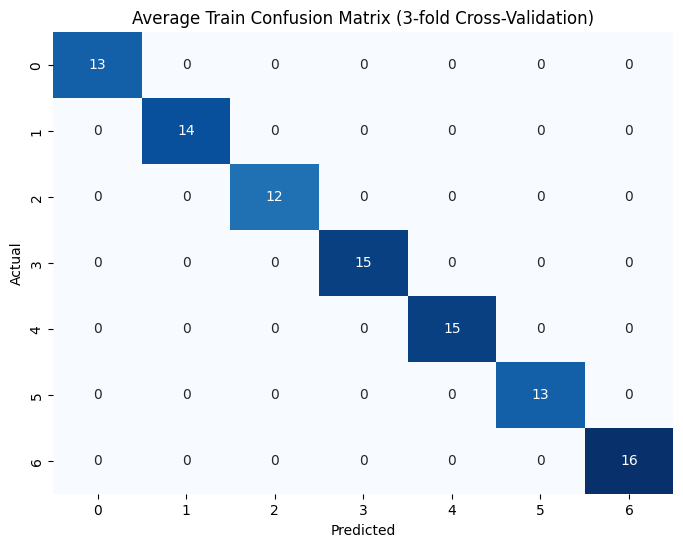

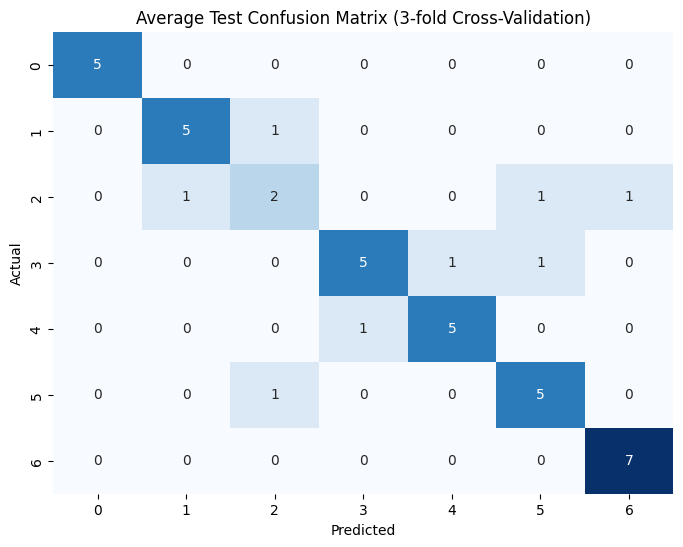

Accuracy: 73.48% after 3 runs


In [45]:

from sklearn.neural_network import MLPClassifier

kf = KFold(n_splits=3)
fold_runs = 0  # Seguimiento de las iteraciones
final_score = 0  
MatrizC_train = np.zeros((7, 7)) 
MatrizC_test = np.zeros((7, 7))   

#validación cruzada
for train_i, test_i in kf.split(X_train):
    
    mlp = MLPClassifier(hidden_layer_sizes=(8, 8, 8), activation='tanh', solver='lbfgs', max_iter=2000)
    fold_runs += 1
    mlp.fit(X_train[train_i], y_train[train_i])

    y_pred_test = mlp.predict(X_train[test_i])
    y_pred_train = mlp.predict(X_train[train_i])

    cm_test = confusion_matrix(y_train[test_i], y_pred_test)
    cm_train = confusion_matrix(y_train[train_i], y_pred_train)

    outVal = mlp.score(X_train[test_i], y_train[test_i])
    final_score += outVal
    
    MatrizC_test[:cm_test.shape[0], :cm_test.shape[1]] += cm_test
    MatrizC_train[:cm_train.shape[0], :cm_train.shape[1]] += cm_train
    
MatrizC_train /= fold_runs
MatrizC_test /= fold_runs

plt.figure(figsize=(8, 6))
sns.heatmap(np.floor(MatrizC_train), annot=True, fmt="g", cmap="Blues", cbar=False)
plt.title('Average Train Confusion Matrix ({}-fold Cross-Validation)'.format(fold_runs))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(np.floor(MatrizC_test), annot=True, fmt="g", cmap="Blues", cbar=False)
plt.title('Average Test Confusion Matrix ({}-fold Cross-Validation)'.format(fold_runs))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print('Accuracy: ' + str(round(final_score * 100 / fold_runs, 2)) + '% after ' + str(fold_runs) + ' runs')

C:\Users\Juan Manuel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Juan Manuel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Juan Manuel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.w

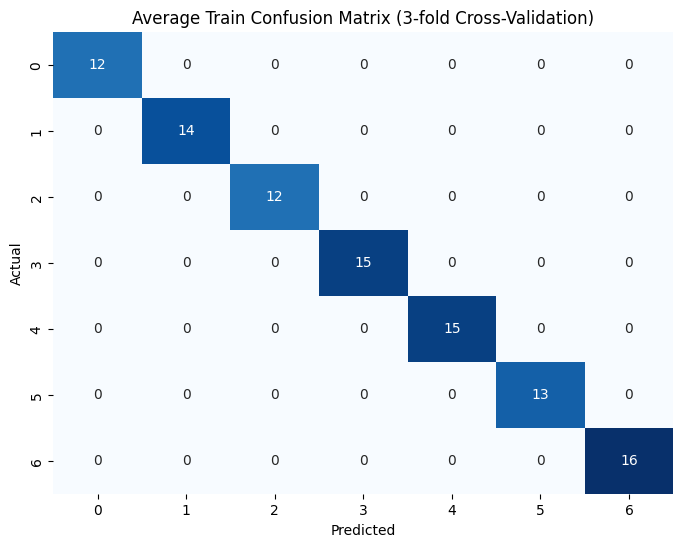

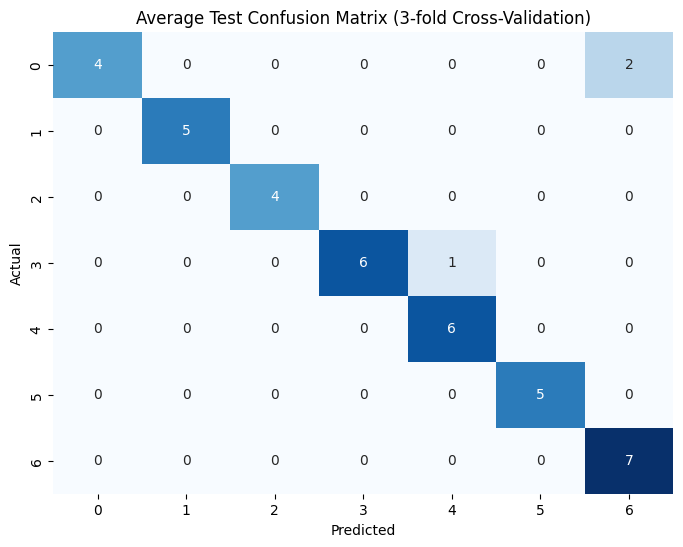

Accuracy: 78.13% after 3 runs


In [52]:

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Se busca con la funcion GridSearchCV poder encontrar los mejores hiperparametros para que la red obtenga la mejor precision
param_grid = {
    'hidden_layer_sizes': [(80,), (20, 20), (80, 80), (80,10)],
    'activation': ['tanh', 'relu'],
    'solver': ['adam', 'sgd']
}

mlp = MLPClassifier(max_iter=2000)
grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, cv=3)
grid_search.fit(X_train_scaled, y_train)

mlp_best = grid_search.best_estimator_

kf = StratifiedKFold(n_splits=3)
fold_runs = 0
final_score = 0
MatrizC_train = np.zeros((7, 7))
MatrizC_test = np.zeros((7, 7))

for train_i, test_i in kf.split(X_train_scaled, y_train):
    X_train_fold, X_test_fold = X_train_scaled[train_i], X_train_scaled[test_i]
    y_train_fold, y_test_fold = y_train[train_i], y_train[test_i]
    
    mlp_best.fit(X_train_fold, y_train_fold)
    
    y_pred_test = mlp_best.predict(X_test_fold)
    y_pred_train = mlp_best.predict(X_train_fold)
    
    cm_test = confusion_matrix(y_test_fold, y_pred_test)
    cm_train = confusion_matrix(y_train_fold, y_pred_train)
    
    outVal = mlp_best.score(X_test_fold, y_test_fold)
    final_score += outVal
    
    MatrizC_test += cm_test
    MatrizC_train += cm_train
    
    fold_runs += 1

MatrizC_train /= fold_runs
MatrizC_test /= fold_runs

plt.figure(figsize=(8, 6))
sns.heatmap(np.floor(MatrizC_train), annot=True, fmt="g", cmap="Blues", cbar=False)
plt.title('Average Train Confusion Matrix ({}-fold Cross-Validation)'.format(fold_runs))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(np.floor(MatrizC_test), annot=True, fmt="g", cmap="Blues", cbar=False)
plt.title('Average Test Confusion Matrix ({}-fold Cross-Validation)'.format(fold_runs))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print('Accuracy: ' + str(round(final_score * 100 / fold_runs, 2)) + '% after ' + str(fold_runs) + ' runs')


In [53]:
mlp_best

MLPClassifier(activation='tanh', hidden_layer_sizes=(80, 80), max_iter=2000)

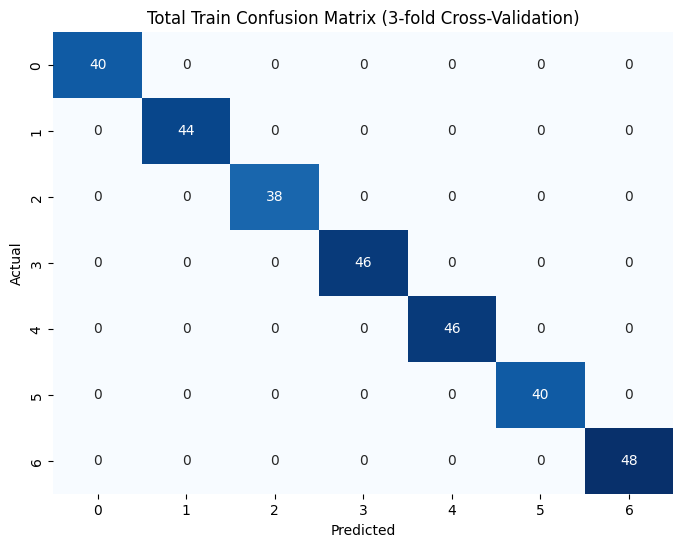

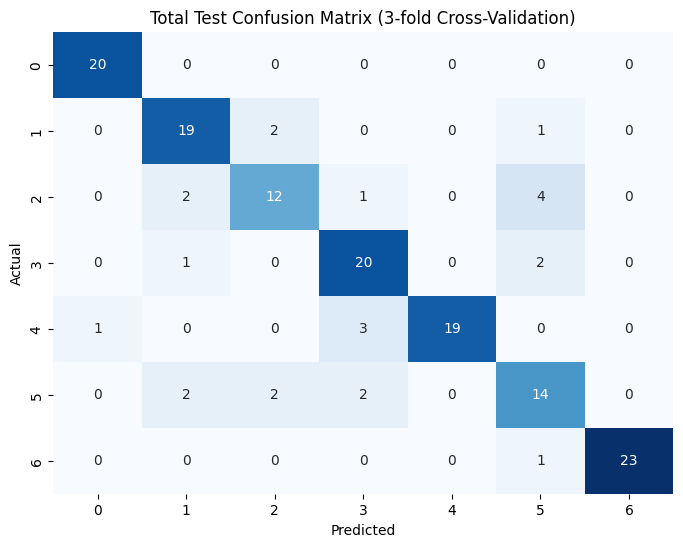

Accuracy: 84.12% after 3 runs


In [62]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold


kf = KFold(n_splits=3)
fold_runs = 0  # Seguimiento de las iteraciones
final_score = 0  # Puntaje final
total_cm_train = np.zeros((7, 7), dtype=int)  # Ajustar al tamaño necesario
total_cm_test = np.zeros((7, 7), dtype=int)  

# Se vuelve a realizar validacion cruzada porque el dataset es pequeno
for train_i, test_i in kf.split(X_train):
    # Se utiliza el modelo randomForest mulimodal
    modelo = RandomForestClassifier(n_estimators=400, criterion='gini', max_features=4, oob_score=True, n_jobs=-1, random_state=123)
    fold_runs += 1
    modelo.fit(X_train[train_i], y_train[train_i])

    y_pred_test = modelo.predict(X_train[test_i])
    y_pred_train = modelo.predict(X_train[train_i])

    cm_test = confusion_matrix(y_train[test_i], y_pred_test)
    cm_train = confusion_matrix(y_train[train_i], y_pred_train)

    outVal = modelo.score(X_train[test_i], y_train[test_i])
    final_score += outVal
    

    total_cm_test += cm_test
    total_cm_train += cm_train
    
plt.figure(figsize=(8, 6))
sns.heatmap(total_cm_train, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Total Train Confusion Matrix ({}-fold Cross-Validation)'.format(fold_runs))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(total_cm_test, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Total Test Confusion Matrix ({}-fold Cross-Validation)'.format(fold_runs))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print('Accuracy: ' + str(round(final_score * 100 / fold_runs, 2)) + '% after ' + str(fold_runs) + ' runs')


Para clasificar los gestos captados mediante señales EMG, se implementó un modelo de machine learning. En la evaluación se consideraron tres modelos: árboles de decisión, máquinas de vectores de soporte (SVM), y el modelo de Random Forest. Los árboles de decisión son adecuados para situaciones muy precisas, mientras que las SVM se utilizan principalmente para problemas de regresión lineal.

El modelo de Random Forest, que fue el seleccionado, emplea múltiples árboles de decisión para separar y clasificar tanto salidas binarias como multimodales. Se construyó y validó el modelo utilizando una matriz de confusión, logrando un ajuste del 100% en los datos de entrenamiento y un 84.12% en los datos de prueba. Estos resultados reflejan un rendimiento excepcional del modelo.

El ajuste del modelo fue evaluado con diferentes configuraciones. Con 400 árboles y una configuración de max_features igual a 4, se obtuvo el mencionado 84.12% de precisión en los datos de prueba. Sin embargo, al reducir el número de árboles a 100, la precisión solo disminuyó ligeramente al 81%. Esto indica que el aumento del número de árboles más allá de los 100 no mejora significativamente el rendimiento del modelo.

El modelo Random Forest demostró ser altamente eficaz para la clasificación de gestos EMG, con una precisión sólida tanto en el entrenamiento como en la prueba, y una mejora marginal al incrementar el número de árboles más allá de los 100.

##### *g. (15%) Discutir cómo se podría implementar la solución del punto e y f usando sistemas embebidos seleccionando el tipo de microcontrolador (5%) y los posibles tiempos de adquisición y clasificación de las señales (10%)*

Para implementar las soluciones propuestas de redes neuronales del presente proyecto para la clasificación de siete tipos de movimientos con ayuda de un modelo de predicción, se utilizaría un dispositivo NVIDIA Jetson Nano, el cual es una dispositivo de placa de circuito único que combina un procesador, GPU, memoria y varias interfaces en un solo módulo compacto cumpliendo con un bajo consumo energético. Además, está diseñado específicamente para aplicaciones de inteligencia artificial y soporta otras redes neuronales. Es un sistema embebido que tendría un muy buen soporte para alrgoritmos de machine learning de salida no binaria y multimodal como la implementada en el proyecto, tal y como se utiliza en [4]. 

Para el sistema de clasificación de las señales se tomarían señales EMG y se clasificarían utilizando un modelo de Deep Learning, específicamente una Red Neuronal Convolucional (CNN) según los 7 tipos de gestos de interés 1 - mano en reposo, 2 - mano cerrada en un puño, 3 - flexión de muñeca, 4 - extensión de muñeca, 5 - desviaciones radiales, 6 - desviaciones cubitales, 7 - palma extendida, dado que este modelo muestra tener un accuracy alto en salidas multimodales provenientes de bioseñales como ECG como se demuestra en [4]. Respecto a los posibles tiempos de adquisición es importante tener en cuenta la velocidad de procesamiento del dispositivo y la frecuencia de muestreo de las señales de EMG, por lo tanto, se escogería la captura de las señales EMG a una frecuencia de 1000Hz en ventanas de señal de escala de milisegundos para lograr una identificación en tiempo real, pues el Jetson Nano debería ser capaz de procesar y almacenar los datos en tiempo real sin problemas.

### Referencias

[1] Tang, S., Dunnmon, J. A., Liangqiong, Q., Saab, K. K., Baykaner, T., Lee-Messer, C., & Rubin, D. L. (2023, June). Modeling multivariate biosignals with graph neural networks and structured state space models. In Conference on Health, Inference, and Learning (pp. 50-71). PMLR.

[2] Mohanty, M., & Palo, H. (2018). Machine Learning: An Effective Technique in Bio-Medical Signal Analysis and Classification. International Journal of Machine Learning and Networked Collaborative Engineering, 1(01), 1-8.

[3] David, Belo., João, Rodrigues., João, R., Vaz., João, R., Vaz., João, R., Vaz., Pedro, Pezarat-Correia., Hugo, Gamboa. (2017). Biosignals learning and synthesis using deep neural networks. Biomedical Engineering Online,  doi: 10.1186/S12938-017-0405-0.

[4] Caesarendra, W., Hishamuddin, T. A., Lai, D. T. C., Husaini, A., Nurhasanah, L., Glowacz, A., & Alfarisy, G. A. F. (2022). An embedded system using convolutional neural network model for online and real-time ECG signal classification and prediction. Diagnostics, 12(4), 795.